# Proyecto Voz Cliente

Este notebook alberga el código y los distintos modelos para explotar las respuestas abiertas de las encuestas de voz cliente. 

El proceso que se sigue es:

    1. Determinar qué comentarios son útiles
    2. Calcular su sentiment
    3. Categorizarlos en categorías predefinidas
    

--------------------------------------------

Importamos las librerías necesarias

In [759]:
import pandas as pd
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import unicodedata
import re

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn import metrics, svm, preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.utils.extmath import softmax

from collections import Counter
import spacy
import stanza
import itertools
from joblib import Parallel, delayed
import category_encoders as ce
from category_encoders.target_encoder import TargetEncoder
import pickle
from joblib import Parallel, delayed
nlp_st = stanza.Pipeline(lang='es', processors='tokenize,lemma')
np.random.seed(500)

tokenizer = ToktokTokenizer()
stopword_list = set(nltk.corpus.stopwords.words('spanish'))
exclude_words = set(("pero", "no"))
stopword_list = list(stopword_list.difference(exclude_words))
pd.set_option('display.max_rows', 500)

2021-08-25 18:08:08 WARNING: Language es package default expects mwt, which has been added
2021-08-25 18:08:08 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| lemma     | ancora  |

2021-08-25 18:08:08 INFO: Use device: cpu
2021-08-25 18:08:08 INFO: Loading: tokenize
2021-08-25 18:08:08 INFO: Loading: mwt
2021-08-25 18:08:08 INFO: Loading: lemma
2021-08-25 18:08:08 INFO: Done loading processors!


Definimos una lista propia de stopwords que se añadirá a la que viene predeterminada para eliminar estas palabras del texto

In [760]:
stopword_list.append('para')
stopword_list.append('pues')
stopword_list.append('hola')
stopword_list.append('adiós')
stopword_list.append('mas')
stopword_list.append('si')
stopword_list.append('sí')
stopword_list.append('chao')
stopword_list.append('alo')
stopword_list.append('ahi')
stopword_list.append('aqui')
stopword_list.append('alli')
stopword_list.append('asi')
stopword_list.append('entonces')
stopword_list.append('cosa')

----------------------------

## Utilidad

Para determinar la utilidad de los verbatims se han definido 2 clases:

    - preprocessing_utilidad: clase donde se lleva a cabo una limpieza de la respuesta abierta de las encuestas.
    
    - prediccion_utilidad: clase donde se realiza la unificación de probabilidades de las frases de comentarios de 2-3 frases y predice la utilidad de cada frase y verbatim.
    
Inputs de las dos clases:

    - ruta_verb_tagged_predicciones: Ruta donde se encuentran los verbatims que se quieren clasificar
    
    - ruta_verb_etiquetados_variables_xfrases: Ruta donde se encuentra el dataframe con los comentarios limpios y divididos en frases junto con las variables usadas para entrenar el modelo. (Este df se crea en la plataforma)
                                               
    - ruta_verb_etiquetados_variables_xfrases_get4: Ruta donde se encuentra el dataframe con los comentarios limpios de 4 o más frases junto con las variables usadas para entrenar el modelo. (Este df se crea en la plataforma)
                                                    
    - pos_model: Modelo de clasificación de utilidad de verbatims de alta satisfacción.
    
    - neg_model: Modelo de clasificación de utilidad de verbatims de baja satisfacción.
    
    - neu_model: Modelo de clasificación de utilidad de verbatims de satisfacción neutra.
    
    - "unification_model_k_j.sav" siendo k el modelo que unifica probabilidades de alta/baja o satis neutra y j el valor que indica si el modelo es para comentarios de 2 o de 3 frases.

In [349]:
class preprocessing_utilidad:
    '''
    clase donde se lleva a cabo una limpieza de la respuesta abierta de las encuestas. 
    '''
    
    def __init__(self, ruta_verb_tagged_predicciones):
        self.ruta_verb_predicciones = ruta_verb_tagged_predicciones
        
    def remove_accented_chars(self, text):
        '''
        Eliminamos los acentos y convertimos y estandarizamos el texto a caracteres ASCII
        '''
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        return text

    
    def remove_special_characters(self, text, remove_digits=False, remove_dots=True, remove_accents=True):
        '''
        Eliminamos los caracteres especiales. 
        Puesto que los números pueden ser de utilidad dependiendo de la finalidad del análisis,
        se deja como opcional su eliminación.
        '''
        if not remove_dots and remove_accents==True:
            pattern = r'[^a-zA-z0-9.\s]' if not remove_digits else r'[^a-zA-z.\s]'
        if not remove_dots and remove_accents==False:
            pattern = r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ./]' if not remove_digits else r'[^ \nA-Za-z-À-ÖØ-öø-ÿ./]'
        if remove_dots==True and remove_accents==False:
            pattern = r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]' if not remove_digits else r'[^ \nA-Za-z-À-ÖØ-öø-ÿ/]'
        if remove_dots==True and remove_accents==True:
            pattern = r'[^ \nA-Za-z0-9/]' if not remove_digits else r'[^ \nA-Za-z/]'
        text = re.sub(pattern, '', text)
        return text
 
    def remove_stopwords(self, text, is_lower_case=False):
        '''
        Eliminamos las stopwords
        '''
        tokens = tokenizer.tokenize(text)
        tokens = [token.strip() for token in tokens]
        if is_lower_case:
            filtered_tokens = [token for token in tokens if token not in stopword_list]
        else:
            filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
        filtered_text = ' '.join(filtered_tokens)    
        return filtered_text

    def lemmatizer_stanza(self, text):
        '''
        Lematizamos el texto con la librería stanza
        '''
        doc = nlp_st(text)
        return ' '.join([word.lemma for sent in doc.sentences for word in sent.words])

    def lemmatizer_parallel(self, dataframe, numb):
        '''
        Paralelizamos la lematización del texto llevada a cabo por la función "lematizer_stanza"
        '''
        comment = self.lemmatizer_stanza(dataframe['respuesta_corta'].iloc[numb])
        return comment
    
    def preprocessing_predicciones(self):
        '''
        Función que realiza todo el proceso de limpieza de verbatims
        '''
        # Leemos el fichero que contenga los verbatims de interés
        self.df = pd.read_excel(self.ruta_verb_predicciones)
        
        # Se estandarizan las columnas
        variables = self.df.columns
        newVariables = [x.replace(" ", "").lower() for x in variables]
        newVariables = [self.remove_accented_chars(x) for x in newVariables]
        self.df.columns = newVariables
        
        # Se trabaja solo con verbatims con indicadores de satisfacción servicio/agente bien definidos
        scores = ['1','2','3','4','5']
        val_replace = self.df['indicadorsatisfaccionservicio'][~self.df.indicadorsatisfaccionservicio.isin(scores)].unique()
        val_replace_2 = self.df['indicadorsatisfaccionagente'][~self.df.indicadorsatisfaccionagente.isin(scores)].unique()

        self.df['indicadorsatisfaccionservicio']=self.df['indicadorsatisfaccionservicio'].replace(val_replace, np.nan)
        self.df['indicadorsatisfaccionagente']=self.df['indicadorsatisfaccionagente'].replace(val_replace_2, np.nan)
        self.df['indicador_satis'] = self.df['indicadorsatisfaccionservicio'].fillna(self.df['indicadorsatisfaccionagente'])
        self.df.indicador_satis.dropna(inplace=True)
        self.df.indicador_satis=self.df.indicador_satis.astype(int)
        
        # Se unifican los distintos valores de la variable "indicador_satis" en una variable de tres valores diferentes 
        conditions = [
            (self.df['indicador_satis'] <= 2),
            (self.df['indicador_satis'] > 2) & (self.df['indicador_satis'] <4 ),
            (self.df['indicador_satis'] >= 4)]
        values_cat = [-1, 0, 1]
        self.df['satis_cat'] = np.select(conditions, values_cat)
        
        # Creamos una variable binaria para los indicadores de satisfacción alta
        conditions = [
        (self.df['indicador_satis'] <4),
        (self.df['indicador_satis'] >= 4)]
        values_cat = [0, 1]
        self.df['class_pos'] = np.select(conditions, values_cat)
        
        # Creamos una variable binaria para los indicadores de satisfacción neutra
        conditions = [
            (self.df['indicador_satis'] >2) & (self.df["indicador_satis"]<4),
            (self.df['indicador_satis'] >= 4),
            (self.df['indicador_satis'] <= 2)]
        values_cat = [1, 0,0]
        self.df['class_neu'] = np.select(conditions, values_cat)
        
        # Creamos una variable binaria para los indicadores de satisfacción alta
        conditions = [
            (self.df['indicador_satis'] <=2),
            (self.df['indicador_satis'] > 2)]
        values_cat = [1, 0]
        self.df['class_neg'] = np.select(conditions, values_cat)
        
        # Limpieza de texto
        # Quitamos los saltos de línas, contamos el número de palabras por frase y nos quedamos con los comentarios que estén
        # compuestos por 4 o más palabras, quitamos las tildes y los caracteres especiales, convertimos el texto a minúscula y
        # quitamos duplicados.
        self.df_duplis = self.df[self.df['respuestaabierta'].notna()].replace('\n','', regex=True)
        self.df_duplis['num_palabras'] = self.df_duplis.respuestaabierta.apply(lambda x: self.remove_special_characters(str(x))).str.split().str.len()
        self.df_duplis = self.df_duplis[self.df_duplis.num_palabras>3]
        self.df_duplis['respuesta_corta'] = self.df_duplis['respuestaabierta'].apply(lambda x: self.remove_accented_chars(x))
        self.df_duplis['respuesta_corta'] = self.df_duplis['respuesta_corta'].apply(lambda x: self.remove_special_characters(x, True, True))
        self.df_duplis['respuesta_corta'] = self.df_duplis['respuesta_corta'].apply(lambda x: x.lower())
        self.df_duplis = self.df_duplis.drop_duplicates(subset='respuesta_corta', keep='first')
        idx = self.df_duplis.idcontacto.unique()
        del self.df_duplis
        
        # Nos quedamos únicamente con los comentarios que no están duplicados y con una sola copia de los duplicados y volvemos
        # a repetir todo el proceso de limpieza anterior. A diferencia del párrafo anterior, no quitamos los puntos, ya que nos
        # interesa dejarlos para poder dividir los comentarios en frases. Quitamos también las stopwords
        self.df1 = self.df[self.df.idcontacto.isin(idx)]
        self.df1['respuestaabierta'] = self.df1['respuestaabierta'].apply(lambda x: x.replace('\n', ''))
        self.df1['respuesta_corta'] = self.df1['respuestaabierta'].apply(lambda x: self.remove_special_characters(x, True, False, False))
        self.df1['respuesta_corta'] = self.df1['respuesta_corta'].apply(lambda x: x.lower())
        self.df1['respuesta_corta'] = self.df1['respuesta_corta'].apply(lambda x: x.replace('\n', ''))
        self.df1['respuesta_corta'] = self.df1['respuesta_corta'].apply(lambda x: x.replace('. ', ' . ', x.count('.')).replace('.', ' . ', x.count('.')))
        self.df1['respuesta_corta'] = self.df1['respuesta_corta'].apply(lambda x: self.remove_stopwords(x, False))

        # Lematizamos todos los comentarios limpios y transformamos los blanks en nans
        results_2 = Parallel(n_jobs=-2, backend='threading', verbose=2)(delayed(self.lemmatizer_parallel)(self.df1,i) for i in range(len(self.df1.respuesta_corta)))
        self.df1['respuesta_corta']=results_2
        self.df1.replace(r'^\s*$', np.nan, regex=True, inplace=True)
        self.df1 = self.df1[self.df1['respuesta_corta'].notna()]
        
        # Como la lematización puede hacer que aparezcan nuevas tildes y stop words, volvemos a ejecutar estas dos funciones  
        self.df1['respuesta_corta'] = self.df1['respuesta_corta'].apply(lambda x: self.remove_accented_chars(x))
        self.df1['respuesta_corta'] = self.df1['respuesta_corta'].apply(lambda x: self.remove_stopwords(x, False))
        
        # Dividimos el texto en frases
        s = self.df1.respuesta_corta.str.split(pat=".",expand=True).stack()
        s.index = s.index.droplevel(-1) # to line up with df's index
        s.name = 'respuesta_corta' # needs a name to join
        del self.df1['respuesta_corta']
        self.df1 = self.df1.join(s)
        
        # Para asegurarnos de que no se nos queda ningún blank por haber quitado las stopwords, volvemos a convertir los blanks
        # en nans.
        self.df1.replace(r'^\s*$', np.nan, regex=True, inplace=True)
        self.df1 = self.df1[self.df1['respuesta_corta'].notna()]
        self.df1 = self.df1[self.df1.indicador_satis.notna()]
        
        # Quitamos los espacios al inicio y al final del comentario y quitamos palabras duplicadas
        self.df1.respuesta_corta = self.df1.respuesta_corta.apply(lambda x: x.strip())
        self.df1['respuesta_corta_nodupl'] = self.df1['respuesta_corta'].apply(lambda x: " ".join((set(x.split()))))
        
        # Seleccionamos las columnas de interés y devolvemos el dataframe con los verbatims limpios
        cols_2=['idcontacto', 'respuestaabierta', 'respuesta_corta', 'respuesta_corta_nodupl', 'canal','negocio', 'perimetro', 'operativa', 'etapa', 'grupointeraccion',
           'contactopasillo', 'indicadorsatisfaccionservicio', 'indicadorsatisfaccionagente', 'satis_cat', 'class_pos', 'class_neg', 'class_neu']
        
        return(self.df1[cols_2])
    
    def preprocessing_predicciones_frases_largas(self):
        '''
        Función que realiza el proceso de limpieza de verbatims para comentarios de 4 o más frases.
        Esto se debe a que en el modelo de unificación de las métricas de cada frase individual, para conseguir una única
        métrica por cada comentario, se hace una predicción por frases de los comentarios de 2-3 frases, mientras que para los de 
        1 y 4>= las predicciones de utilidad se obtienen procesando el verbatim sin divisiones.
        '''
        
        # Leemos el dataframe ya preprocesado y divido en frases y agrupamos por idcontacto (clave única) para calcular el número
        # de frases que componen cada comentario. Nos quedamos con los comentarios que tengan 4 o más frases.Para quedarnos con
        # la respuesta abierta de cada una de estas encuestas quitamos los duplicados y nos quedamos con la primera aparición
        self.df_intermedio = self.preprocessing_predicciones()
        df_counts = pd.DataFrame({'counts': self.df_intermedio.groupby('idcontacto')['respuesta_corta_nodupl'].count()})
        idx_get4 = df_counts[df_counts.counts>=4].index
        self.df_get4 = self.df_intermedio[self.df_intermedio.idcontacto.isin(idx_get4)]
        self.df_get4.drop_duplicates(subset=['idcontacto', 'respuestaabierta'], keep='first', inplace=True)
        
        # Limpiamos el texto de la respuesta abierta para poder emplearlo en el modelo de clasificación de utilidad
        self.df_get4['respuestaabierta'] = self.df_get4['respuestaabierta'].apply(lambda x: x.replace('\n', ''))
        self.df_get4['respuesta_corta'] = self.df_get4['respuestaabierta'].apply(lambda x: self.remove_special_characters(x, True, True, False))
        self.df_get4['respuesta_corta'] = self.df_get4['respuesta_corta'].apply(lambda x: x.lower())
#         self.df_get4['respuesta_corta'] = self.df_get4['respuesta_corta'].apply(lambda x: x.replace('\n', ''))
        self.df_get4['respuesta_corta'] = self.df_get4['respuesta_corta'].apply(lambda x: x.replace('. ', ' . ', x.count('.')).replace('.', ' . ', x.count('.')))
        self.df_get4['respuesta_corta'] = self.df_get4['respuesta_corta'].apply(lambda x: self.remove_stopwords(x, False))
        
        # Lematizamos el texto y quitamos los posibles nans que se hayan producido al quitar las stop words y los caracteres
        # especiales
        results_4 = Parallel(n_jobs=-2, backend='threading', verbose=2)(delayed(self.lemmatizer_parallel)(self.df_get4, i) for i in range(len(self.df_get4.respuesta_corta)))
        self.df_get4['respuesta_corta']=results_4
        self.df_get4.replace(r'^\s*$', np.nan, regex=True, inplace=True)
        self.df_get4 = self.df_get4[self.df_get4['respuesta_corta'].notna()]
        
        # Eliminamos tildes y stopwords que se hayan producido después de la lematización
        self.df_get4['respuesta_corta'] = self.df_get4['respuesta_corta'].apply(lambda x: self.remove_accented_chars(x))
        self.df_get4['respuesta_corta'] = self.df_get4['respuesta_corta'].apply(lambda x: self.remove_stopwords(x, False))
        
        # Quitamos los espacios al inicio y al final de los comentarios y eliminamos palabras duplicadas
        self.df_get4.respuesta_corta = self.df_get4.respuesta_corta.apply(lambda x: x.strip())
        self.df_get4['respuesta_corta_nodupl'] = self.df_get4['respuesta_corta'].apply(lambda x: " ".join((set(x.split()))))
        
        # Seleccionamos las columnas de interés y devolvemos el dataframe con las respuestas abiertas limpias
        cols_2=['idcontacto', 'respuestaabierta', 'respuesta_corta', 'respuesta_corta_nodupl', 'canal','negocio', 'perimetro', 'operativa', 'etapa', 'grupointeraccion',
           'contactopasillo', 'indicadorsatisfaccionservicio', 'indicadorsatisfaccionagente', 'satis_cat', 'class_pos', 'class_neg', 'class_neu']
        return(self.df_get4[cols_2])

Ejecutamos la clase

In [345]:
# Definimos la ruta donde se encuentra el set de datos que queremos clasificar
ruta_set_verbatims_sin_procesar = 'verbatims_clasificados_marta_ana_v2.xlsx' 

u = preprocessing_utilidad(ruta_set_verbatims_sin_procesar)

# Llamamos a las dos funciones de limpieza de texto de la clase para obtener dos dataframes:
# El primero contiene todos los comentarios dividios en frases para poder sacar una predicción por frase
df_prepro_utilidad_x_frases = u.preprocessing_predicciones()
# El segundo contiene las respuestas abiertas de los comentarios de 4 o más frases limpias
df_prepro_utilidad_x_frases_get4 = u.preprocessing_predicciones_frases_largas()

In [347]:
df_prepro_utilidad_x_frases_get4.head()

,idcontacto,respuestaabierta,respuesta_corta,respuesta_corta_nodupl,canal,negocio,perimetro,operativa,etapa,grupointeraccion,contactopasillo,indicadorsatisfaccionservicio,indicadorsatisfaccionagente,satis_cat,class_pos,class_neg,class_neu,categoriai
1,155330379,Quería bueno que hubiese alquiler de mediodía....,querer buen alquiler mediodia dia completo lla...,cerrar completo querer grupo mediodia tema no ...,IVR,Auto Particulares,Autoclub,Servicios,4. Obtengo beneficios,A.4.6 Alquilo un coche,Contrato y uso coche de alquiler a través de M...,5.0,3.0,1,1,0,0,Sugerencia
3,156864731,Está de satisfecho con el el vehículo lo que p...,satisfecho vehiculo pasar no llegar alquilar n...,pasado utilizar ocasion llegar viaje satisfech...,IVR,Auto Particulares,Autoclub,Servicios,4. Obtengo beneficios,A.4.6 Alquilo un coche,Contrato y uso coche de alquiler a través de M...,4.0,4.0,1,1,0,0,Operativa / servicio
4,157695193,No puedo aportar nada más. Todo muy bien ha si...,no poder aportar bien ser amable educado efici...,poder gracias bien amable no luego aportar efi...,IVR,Auto Particulares,Autoclub,Servicios,4. Obtengo beneficios,A.4.6 Alquilo un coche,Contrato y uso coche de alquiler a través de M...,5.0,5.0,1,1,0,0,Operativa / servicio
7,159565531,Pues mira yo pienso que las Islas Canarias. En...,mirar pensar isla canario vez alquilar enterpr...,enterprise vez isla condicion pensar deber per...,IVR,Auto Particulares,Autoclub,Servicios,4. Obtengo beneficios,A.4.6 Alquilo un coche,Contrato y uso coche de alquiler a través de M...,5.0,5.0,1,1,0,0,Sugerencia
16,163939543,Funciona muy bien. Hay servicio. Contento. Est...,funcionar bien servicio contento escuchame moto,servicio escuchame bien moto funcionar contento,IVR,Auto Particulares,Autoclub,Servicios,4. Obtengo beneficios,A.4.6 Alquilo un coche,Contrato y uso coche de alquiler a través de M...,5.0,5.0,1,1,0,0,Satisfacción General


In [348]:
# Guardamos los dataframes en dos csv.
df_prepro_utilidad_x_frases.to_csv('verb_marta_ana_tagged_mod_utilidad.csv', sep='#')
df_prepro_utilidad_x_frases_get4.to_csv('verb_marta_ana_tagged_mod_utilidad_get4.csv', sep='#')

In [369]:
class prediccion_utilidad():
    '''
    Clase que contiene el código para predecir la utilidad de cada verbatim
    así como de cada frase que lo compone.
    
    Las variables de entrada que necesita la clase son:
    
    - ruta_verb_etiquetados_variables_xfrases: Ruta donde se encuentra el dataframe con los comentarios limpios y divididos 
                                               en frases junto con las variables usadas para entrenar el modelo.
                                               (Este df se crea en la plataforma)
    - ruta_verb_etiquetados_variables_xfrases_get4: Ruta donde se encuentra el dataframe con los comentarios limpios de 
                                                    4 o más frases junto con las variables usadas para entrenar el modelo.
                                                    (Este df se crea en la plataforma)
    - pos_model: Modelo de clasificación de utilidad de verbatims de alta satisfacción.
    - neg_model: Modelo de clasificación de utilidad de verbatims de baja satisfacción.
    - neu_model: Modelo de clasificación de utilidad de verbatims de satisfacción neutra.
    '''
    def __init__(self, ruta_verb_etiquetados_variables_xfrases, ruta_verb_etiquetados_variables_xfrases_get4, pos_model, neg_model, neu_model):

        self.df_2_frase = pd.read_csv(ruta_verb_etiquetados_variables_xfrases, sep='#', index_col=0)
        self.df_2_frase_get4 = pd.read_csv(ruta_verb_etiquetados_variables_xfrases_get4, sep='#', index_col=0)
        self.pos_model = pos_model
        self.neg_model = neg_model
        self.neu_model = neu_model

    def modelo_frases(self, dataframe):
        '''
        Función que calcula las probabilidades de cada frase de ser de alta, baja o media satisfacción. 
        '''
        # Definimos las columnas que no van a pasar al modelo para excluirlas de los datasets usados para predecir
        self.cols_avoided = ["canal", "negocio", "perimetro", "operativa", "etapa", "grupointeraccion", "contactopasillo",
                        "indicadorsatisfaccionservicio", "indicadorsatisfaccionagente", "satis_cat",
                        "respuestaabierta", "respuesta_corta", "respuesta_corta_nodupl", "class_pos", "class_neg", "class_neu"]
        
        # Dividimos este último dataset entre las entradas usadas para predecir y la clase con la que se van a comparar las predicciones        
        self.X_test = dataframe.loc[:, ~dataframe.columns.isin(self.cols_avoided)]
        self.y_test_pos = dataframe['class_pos']
        self.y_test_neg = dataframe['class_neg']
        self.y_test_neu = dataframe['class_neu']
        
        # Usamos los modelos de verbatim originales (alta y baja satis y satis neutra) para hacer predicciones
        # de las predicciones de pertenecer a cada clase de satisfacción
        self.y_pred_pos = self.pos_model.predict(self.X_test)
        self.y_pred_proba_pos = self.pos_model.predict_proba(self.X_test)[:,1]

        self.y_pred_neg = self.neg_model.predict(self.X_test)
        self.y_pred_proba_neg = self.neg_model.predict_proba(self.X_test)[:,1]

        self.y_pred_neu = self.neu_model.predict(self.X_test)
        self.y_pred_proba_neu = self.neu_model.predict_proba(self.X_test)[:,1]

        # Añadimos las predicciones en forma de columnas en el dataframe
        dataframe['prob_pos'] = self.y_pred_proba_pos
        dataframe['prob_neg'] = self.y_pred_proba_neg
        dataframe['prob_neu'] = self.y_pred_proba_neu
        
        # Creamos un id único compuesto por el idcontacto predefinido y un contador
        dataframe = dataframe.reset_index()
        dataframe['id_unico'] = dataframe.idcontacto.astype(str)+'_'+dataframe.index.astype(str)
        return(dataframe)
        
    def filtrado_escalonado(self):
        '''
        Función que realiza el filtrado escalonado de verbatims:
        1 - Categorizamos como de alta satisfacción aquellos verbatims cuya probabilidad de ser de alta satis se sitúe por
            encima de 0.7. Estos verbatims se excluirán de los siguientes pasos.
        2 - Categorizamos como comentarios de baja satisfacción aquellos cuya probabilidad de ser de baja satis se encuentre
            por encima de 0.7. Estos verbatims se excluirán del siguiente paso.
        3 - Categorizamos como verbatims de satisfacción neutra aquellos cuya probabilidad de ser de satis neutra se encuentre
            por encima de 0.7. 
        Todos estos verbatims que hemos conseguido categorizar como de alta, baja o satis neutra se considerarán útiles, 
        siendo el resto no útiles.
        '''
        # Seleccionamos los comentarios (o frases) que sean de alta satisfacción (aquellos con una prob superior a 0.7) y 
        # guardamos sus idcontacto para categorizarlos como útiles y excluirlos del resto de pasos del filtrado. 
        self.df_2_frase=self.modelo_frases(self.df_2_frase)
        self.alta_satis_comments = pd.DataFrame({'proba':self.df_2_frase.prob_pos})
        self.alta_satis_comments['class'] = self.alta_satis_comments['proba'].apply(lambda x: 1 if x>=0.7 else 0)
        self.alta_satis_comments['idcontacto'] = self.df_2_frase.id_unico
        self.alta_satis_comments = self.alta_satis_comments.set_index('idcontacto')
        self.df_alta_satis_filtered=self.df_2_frase[self.df_2_frase.id_unico.isin(self.alta_satis_comments[self.alta_satis_comments['class']==1].index)]
        self.alta_satis_filtered_index = self.df_alta_satis_filtered.id_unico
        
        # Seleccionamos los comentarios (o frases) que sean de baja satisfacción (aquellos con una prob superior a 0.7) y 
        # guardamos sus idcontacto para categorizarlos como útiles y excluirlos del último paso del filtrado. 
        self.baja_satis_comments = pd.DataFrame({'proba':self.df_2_frase.prob_neg})
        self.baja_satis_comments['class'] = self.baja_satis_comments['proba'].apply(lambda x: 1 if x>=0.7 else 0)
        self.baja_satis_comments['idcontacto'] = self.df_2_frase.id_unico
        self.baja_satis_comments = self.baja_satis_comments.set_index('idcontacto')
        self.baja_satis_comments_filtered_index = self.baja_satis_comments[~self.baja_satis_comments.index.isin(self.df_alta_satis_filtered.index)][self.baja_satis_comments['class']==1].index
        self.df_baja_satis_filtered=self.df_2_frase[self.df_2_frase.id_unico.isin(self.baja_satis_comments_filtered_index)]
        self.index_neg_pos = np.concatenate([self.alta_satis_filtered_index, self.baja_satis_comments_filtered_index])
        
        # Seleccionamos los comentarios (o frases) que sean de satisfacción neutra (aquellos con una prob superior a 0.7) y 
        # guardamos sus idcontacto para categorizarlos como útiles 
        self.media_satis_comments = pd.DataFrame({'proba':self.df_2_frase.prob_neu})
        self.media_satis_comments['class'] = self.media_satis_comments['proba'].apply(lambda x: 1 if x>=0.7 else 0)
        self.media_satis_comments['idcontacto'] = self.df_2_frase.id_unico
        self.media_satis_comments = self.media_satis_comments.set_index('idcontacto')
        self.media_satis_comments_filtered_index = self.media_satis_comments[~self.media_satis_comments.index.isin(self.index_neg_pos)][self.media_satis_comments['class']==1].index
        self.df_media_satis_filtered=self.df_2_frase[self.df_2_frase.id_unico.isin(self.media_satis_comments_filtered_index)]
        idx_filtered = np.concatenate([self.df_alta_satis_filtered.id_unico, self.df_baja_satis_filtered.id_unico, self.df_media_satis_filtered.id_unico])
        
        # Categorizamos como útiles aquellos comentarios o frases que hayan superado los tres filtros anteriores.
        self.df_2_frase.loc[self.df_2_frase.id_unico.isin(idx_filtered), 'utilidad_frases']='util'
        self.df_2_frase['utilidad_frases'].fillna('no_util', inplace=True)
        
    def df_creation(self, numb_frases, prob_sentiment, class_sentiment):
        '''
        Los modelos de la función "modelo_frases" proporcionan tres probabilidades por frase. Sin embargo, para calcular las 
        "probabilidades" del comentario entero tenemos que unificar las probabilidades individuales de cada frase en una sola.
        
        El objetivo de esta función es unificar las probabilidades de cada frase para proporcionar una probabilidad del
        verbatim entero.
        
        Esta labor de unificación solo tiene lugar en comentarios de 2-3 frases. Para los de 4 o más frases se calcularán las
        probabilidades de cada frase pero, a la hora de calcular la probabilidad del verbatim entero, se optará por pasar el modelo
        inicial de verbatim (pos_model, neg_model y neu_model) al dataframe obtenido de la función 
        "preprocessing_predicciones_frases_largas" de la clase "preprocessing_utilidad".
        ''' 

        # Seleccionamos los índices de los comentarios con menos e igual o más de cuatro frases
        df_counts = pd.DataFrame({'counts': self.df_2_frase.groupby('idcontacto')['respuesta_corta_nodupl'].count()})
        if numb_frases<4:
            id_frases = df_counts[df_counts.counts==numb_frases].index
        else:
            id_frases = df_counts[df_counts.counts>=4].index
        df_n_frases = self.df_2_frase[self.df_2_frase.idcontacto.isin(id_frases)]

        # Seleccionamos la probabilidad y la clase de un único tipo de satisfacción (alta, baja o neutra).
        # Agrupamos por id de forma que las n entradas correspondientes a un único comentario, 
        # se transformen en diferentes columnas
        # Creamos una lista que servirá para nombrar a las columnas que contengan las probabilidades de cada una
        # de las frases de un mismo comentario
        # Convertimos las diferentes entradas en columnas
        # Eliminamos filas duplicadas
        # Añadimos el tipo de satisfacción al dataframe
        df_pos = df_n_frases[['idcontacto', prob_sentiment, class_sentiment]]
        result = df_pos.groupby(['idcontacto'])[prob_sentiment].unique()
        df_pos_prob = pd.DataFrame(result)
        cols = ['prob_{}'.format(i) for i in range(1,numb_frases+1)]
        df_pos_prob[cols] = pd.DataFrame(df_pos_prob[prob_sentiment].tolist(), index=df_pos_prob.index).iloc[:,:4]
        df_pos.drop_duplicates(subset='idcontacto', keep='first', inplace=True)
        df_pos_prob[class_sentiment] = df_pos[[class_sentiment, 'idcontacto']].set_index('idcontacto')  

        # Rellenamos los NaN con los valores de la columna anterior. Esto sucede si en un mismo comentario hay dos frases 
        # que se repiten. De este modo, solo hacemos la predicción para la primera de ella y este valor se usará para
        # completar las probabilidades de las siguientes frases
        [df_pos_prob['prob_{}'.format(i)].fillna(df_pos_prob['prob_{}'.format(i-1)], inplace=True) for i in range(2, numb_frases+1)]

        # Calculamos el resultado de la función logit (ln(x/(1-x))) aplicado a cada probabilidad
        res_log_odds = [np.reshape(df_pos_prob['prob_{}'.format(i)]\
                                   .apply(lambda x: np.log(x)-np.log(1-x)).values, (len(df_pos_prob, )))\
                                    for i in range(1,numb_frases+1)]

        # Creamos una lista de columnas con el nombre de estas nuevas variables
        cols_2 = ['log_odds_{}'.format(i) for i in range(1,numb_frases+1)]

        # Creamos un dataframe con los valores obtenidos al aplicar la función logit a las distintas probabilidades
        df_pos_prob_1 = pd.DataFrame(np.transpose(res_log_odds),index = df_pos_prob.index, columns=[cols_2])
        df_pos_prob_1.columns=cols_2
        df_pos_prob=pd.concat([df_pos_prob,df_pos_prob_1], axis=1)

        # Eliminamos la columna que contiene una lista con las probabilidades de cada una de las frases
        df_pos_prob.drop(columns=prob_sentiment, inplace=True)

        return(df_pos_prob)
    
    def AUC_metric_unification(self, numb_frases):
        '''
        Función que lleva a cabo la unificación de probabilidades de las frases de cada comentario.
        Se trata de una Regresión Logística cuyas variables son los resultados de la función logit (ln(x/x-1))
        
        Los modelos de unificación ya están entrenados y se llaman "unification_model_k_j.sav" siendo k el modelo
        que unifica probabilidades de alta/baja o satis neutra y j el valor que indica si el modelo es para comentarios
        de 2 o de 3 frases.
        '''  
        
        # Aplicamos el modelo de unificación únicamente a comentarios de 2 y 3 frases
        if numb_frases>1 and numb_frases<4:
            for k, j in zip(['prob_pos', 'prob_neg', 'prob_neu'],['class_pos', 'class_neg', 'class_neu']):
                
                # Creamos el dataframe con todas las variables necesarias para poder implementar el modelo
                df_pos_prob = self.df_creation(numb_frases, k, j)

                # Creamos una lista con los nombres de las columnas que contendrán los resultados de aplicar
                # la función logit a las probabilidades de cada frase
                cols_log_odds = ['log_odds_{}'.format(i) for i in range(1,numb_frases+1)]

                # Aplicamos el modelo de unificación de métricas
                lr_1 = pickle.load(open('unification_model_{}_{}.sav'.format(j, numb_frases), 'rb'))
                df_pos_prob['prob_pos_lr_1']=lr_1.predict_proba(df_pos_prob[cols_log_odds])[:,1]

                # Especificamos las probabilidades a partir de las cuales binarizaremos nuestra variable
                conditions_1 = [
                (df_pos_prob['prob_pos_lr_1']<0.5),
                (df_pos_prob["prob_pos_lr_1"]>=0.5)]
                # Variable binaria
                values_cat = [0, 1]
                # Creación de la nueva variable binaria basada en las condiciones y valores anteriormente especificados
                df_pos_prob['class_pos_pred_1'] = np.select(conditions_1, values_cat)

                if k=='prob_pos':
                    probs = df_pos_prob['prob_pos_lr_1']
                else:
                    probs = pd.concat([probs, df_pos_prob['prob_pos_lr_1']], axis=1)
            # Renombramos las columnas del df que contiene las probabilidades unificadas para cada verbatim
            probs.columns=['alta_satis', 'baja_satis', 'media_satis']

        else:
            # Creamos un dataframe que contenga el id de cada comentario junto con el número de frases que lo componen
            df_frases_count = pd.DataFrame(self.df_2_frase.groupby('idcontacto').respuesta_corta_nodupl.count())
            df_frases_count.reset_index(inplace=True)
            df_frases_count.columns=['idcontacto', 'counts']

            # Seleccionamos los id de los comentarios que contengan 1 o >=4 frases
            if numb_frases==1:
                n_frases = list(df_frases_count[df_frases_count.counts==numb_frases].idcontacto.values)
                df_n_frase = self.df_2_frase[self.df_2_frase.idcontacto.isin(n_frases)]
            else:
                df_n_frase=self.modelo_frases(self.df_2_frase_get4)

            # Nos quedamos únicamente con los comentarios que estén compuestos por n frases
            probs = df_n_frase[['idcontacto', 'prob_pos', 'prob_neg', 'prob_neu']]
            probs.columns=['idcontacto','alta_satis', 'baja_satis', 'media_satis']
            probs.set_index('idcontacto', inplace=True)
        return(probs)

    def df_unification_metric(self):
        for i in range(1,5):
            if i==1:
                self.df_probs_1 = self.AUC_metric_unification(i)
            else:
                self.df_probs_2 = self.AUC_metric_unification(i)
                self.df_probs_1=self.df_probs_1.append(self.df_probs_2)
        return(self.df_probs_1)
    
    def filtrado_escalonado_2(self):
        '''        
        Función que realiza el filtrado escalonado de verbatims:
        1 - Categorizamos como de alta satisfacción aquellos verbatims cuya probabilidad de ser de alta satis se sitúe por
            encima de 0.7. Estos verbatims se excluirán de los siguientes pasos.
        2 - Categorizamos como comentarios de baja satisfacción aquellos cuya probabilidad de ser de baja satis se encuentre
            por encima de 0.7. Estos verbatims se excluirán del siguiente paso.
        3 - Categorizamos como verbatims de satisfacción neutra aquellos cuya probabilidad de ser de satis neutra se encuentre
            por encima de 0.7. 
        Todos estos verbatims que hemos conseguido categorizar como de alta, baja o satis neutra se considerarán útiles, 
        siendo el resto no útiles.
        '''
        self.df_probs_1 = self.df_unification_metric()
        print('len df_probs_1', len(self.df_probs_1))
        print('len_df_probs_2', len(self.df_2_frase))
        self.alta_satis_comments = pd.DataFrame({'proba':self.df_probs_1.alta_satis})
        self.alta_satis_comments['class'] = self.df_probs_1['alta_satis'].apply(lambda x: 1 if x>=0.7 else 0)
        self.alta_satis_comments['idcontacto'] = self.df_probs_1.index
        self.df_alta_satis_filtered=self.df_probs_1[self.df_probs_1.index.isin(self.alta_satis_comments[self.alta_satis_comments['class']==1].index)]
        self.alta_satis_filtered_index = self.df_alta_satis_filtered.index.unique()
        
        self.baja_satis_comments = pd.DataFrame({'proba':self.df_probs_1.baja_satis})
        self.baja_satis_comments['class'] = self.df_probs_1['baja_satis'].apply(lambda x: 1 if x>=0.7 else 0)
        self.baja_satis_comments['idcontacto'] = self.df_probs_1.index
        self.baja_satis_comments_filtered_index_1=self.baja_satis_comments[~self.baja_satis_comments.index.isin(self.df_alta_satis_filtered.index)]
        self.baja_satis_comments_filtered_index=self.baja_satis_comments_filtered_index_1[self.baja_satis_comments_filtered_index_1['class']==1].index
        self.df_baja_satis_filtered=self.df_probs_1[self.df_probs_1.index.isin(self.baja_satis_comments_filtered_index)]
        
        self.index_neg_pos = np.concatenate([self.alta_satis_filtered_index, self.baja_satis_comments_filtered_index])
        
        self.media_satis_comments = pd.DataFrame({'proba':self.df_probs_1.media_satis})
        self.media_satis_comments['class'] = self.df_probs_1['media_satis'].apply(lambda x: 1 if x>=0.7 else 0)
        self.media_satis_comments['idcontacto'] = self.df_probs_1.index
        self.media_satis_comments_filtered_index_1=self.media_satis_comments[~self.media_satis_comments.index.isin(self.index_neg_pos)]
        self.media_satis_comments_filtered_index=self.media_satis_comments_filtered_index_1[self.media_satis_comments_filtered_index_1['class']==1].index
        self.df_media_satis_filtered=self.df_probs_1[self.df_probs_1.index.isin(self.media_satis_comments_filtered_index)]
        
        idx_filtered = np.concatenate([self.df_alta_satis_filtered.index, self.df_baja_satis_filtered.index, self.df_media_satis_filtered.index])
        self.df_2_frase.loc[self.df_2_frase.idcontacto.isin(idx_filtered), 'utilidad']='util'
        self.df_2_frase['utilidad'].fillna('no_util', inplace=True)
        
        self.df_probs_1=self.df_probs_1.reset_index()
        self.df_probs_1.columns=['idcontacto','alta_satis', 'baja_satis', 'media_satis']
        self.df_probs_1['idcontacto'] = self.df_probs_1['idcontacto'].astype(int)
        self.df_probs_1.set_index('idcontacto', inplace=True)
        
        cols_fin = ['idcontacto', 'id_unico']+self.cols_avoided+['utilidad_frases', 'prob_pos', 'prob_neg', 'prob_neu','utilidad']
        self.df_final=self.df_2_frase[cols_fin].merge(self.df_probs_1, left_on='idcontacto', right_on='idcontacto')
        self.df_final=self.df_2_frase[cols_fin].join(self.df_probs_1, lsuffix='_', on='idcontacto')
        self.df_final.drop_duplicates(['id_unico'], keep='first', inplace=True)
        return(self.df_final)

Ejecutamos la clase

In [370]:
pos_model = pickle.load(open('final_model_positive.sav', 'rb'))
neg_model = pickle.load(open('final_model_negative.sav', 'rb'))
neu_model = pickle.load(open('final_model_neutral.sav', 'rb'))
pu = prediccion_utilidad('2021-08-24_verb_tagged_marta_ana_xfrases_frec500_variablesverbatim.csv', 
                        '2021-08-24_verb_tagged_marta_ana_xfrases_get4_frec500_variablesverbatim.csv', 
                        pos_model, neg_model, neu_model)
pu.filtrado_escalonado()
df_final = pu.filtrado_escalonado_2()

Guardamos en un csv el dataframe con las predicciones de utilidad para cada frase y el comentario entero

In [698]:
df_final.to_csv('predicciones_parte_utilidad_clases.csv')

In [382]:
idx_utiles = df_final[df_final['utilidad']=='util'].idcontacto.unique()

In [697]:
df_final.head()

,idcontacto,id_unico,canal,negocio,perimetro,operativa,etapa,grupointeraccion,contactopasillo,indicadorsatisfaccionservicio,...,class_neg,class_neu,utilidad_frases,prob_pos,prob_neg,prob_neu,utilidad,alta_satis,baja_satis,media_satis
0,155330379,155330379_0,IVR,Auto Particulares,Autoclub,Servicios,4. Obtengo beneficios,A.4.6 Alquilo un coche,Contrato y uso coche de alquiler a través de M...,5.0,...,0,0,util,0.799029,0.167328,0.338128,no_util,0.346641,0.568963,0.447533
1,155330379,155330379_1,IVR,Auto Particulares,Autoclub,Servicios,4. Obtengo beneficios,A.4.6 Alquilo un coche,Contrato y uso coche de alquiler a través de M...,5.0,...,0,0,no_util,0.622229,0.388134,0.409848,no_util,0.346641,0.568963,0.447533
2,155330379,155330379_2,IVR,Auto Particulares,Autoclub,Servicios,4. Obtengo beneficios,A.4.6 Alquilo un coche,Contrato y uso coche de alquiler a través de M...,5.0,...,0,0,util,0.229569,0.799851,0.519246,no_util,0.346641,0.568963,0.447533
3,155330379,155330379_3,IVR,Auto Particulares,Autoclub,Servicios,4. Obtengo beneficios,A.4.6 Alquilo un coche,Contrato y uso coche de alquiler a través de M...,5.0,...,0,0,no_util,0.480713,0.474471,0.601187,no_util,0.346641,0.568963,0.447533
4,156864731,156864731_4,IVR,Auto Particulares,Autoclub,Servicios,4. Obtengo beneficios,A.4.6 Alquilo un coche,Contrato y uso coche de alquiler a través de M...,4.0,...,0,0,no_util,0.645656,0.373480,0.283994,util,0.556674,0.299963,0.729850


## Clasificación semántica

El siguiente paso en la explotación de la respuesta abierta es la clasificación semántica.

Clasificar semánticamente un comentario es, dependiendo del tema del que trate, asignarle una categoría predefinida por negocio.

Para realizar este proceso se han creado 3 clases diferentes:
    1. semantic_classification_preprocessing
    2. semantic_classification_training
    3. semantic_classification_predictions

In [984]:
class semantic_classification_preprocessing:
    '''
    Clase que limpia el texto de las respuestas abiertas de los verbatims clasificados como útiles por Marta y Ana
    para extraer las palabras discriminantes de cada categoría y entrenar un modelo de topic classification. 
    '''
    def __init__(self, path_verbatims_etiquetados):
        '''
        El input "path_verbatims_etiquetados" hace referencia al dataset con los verbatims ya etiquetados como
        útiles/no útiles
        '''
        # Nos quedamos únicamente con los verbatims etiquetados como útiles y seleccionamos de éstos
        # las variables de interés para proceder a su clasificación
        self.df1 = pd.read_excel(path_verbatims_etiquetados)
        self.df1 = self.df1[self.df1['Utilidad Verbatim']=='Útil']
        self.df2 = self.df1[['IdContacto', 'Negocio', 'Perímetro', 'Operativa', 'Etapa',
       'Grupo Interacción', 'Contacto Pasillo', 'Respuesta Abierta', 'Categoría I']]
        
    def remove_accented_chars(self, text):
        '''
        Eliminamos los acentos y convertimos y estandarizamos el texto a caracteres ASCII
        '''
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        return text
    
    
    def remove_special_characters(self, text, remove_digits=False, remove_dots=True, remove_accents=True):
        '''
        Eliminamos los caracteres especiales. Puesto que los números pueden ser de utilidad dependiendo
        de la finalidad del análisis, se deja como opcional su eliminación.
        '''
        if not remove_dots and remove_accents==True:
            pattern = r'[^a-zA-z0-9.\s]' if not remove_digits else r'[^a-zA-z.\s]'
        if not remove_dots and remove_accents==False:
            pattern = r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ./]' if not remove_digits else r'[^ \nA-Za-z-À-ÖØ-öø-ÿ./]'
        if remove_dots==True and remove_accents==False:
            pattern = r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]' if not remove_digits else r'[^ \nA-Za-z-À-ÖØ-öø-ÿ/]'
        if remove_dots==True and remove_accents==True:
            pattern = r'[^ \nA-Za-z0-9/]' if not remove_digits else r'[^ \nA-Za-z/]'
        text = re.sub(pattern, '', text)
        return text
    
    def remove_special_characters_2(self, text):
        '''
        Eliminamos los caracteres especiales.
        '''
        pattern = r'[^A-Za-z0-9 ]+'
        text = re.sub(pattern, '', text)
        return text

    def remove_stopwords(self, text, is_lower_case=False):
        '''
        Eliminamos las stopwords
        '''
        tokens = tokenizer.tokenize(text)
        tokens = [token.strip() for token in tokens]
        if is_lower_case:
            filtered_tokens = [token for token in tokens if token not in stopword_list]
        else:
            filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
        filtered_text = ' '.join(filtered_tokens)    
        return filtered_text
    
    def lemmatizer_stanza(self, text):
        '''
        Lematizamos el texto con la librería stanza
        '''
        doc = nlp_st(text)
        return ' '.join([word.lemma for sent in doc.sentences for word in sent.words])

    def lemmatizer_parallel(self, dataframe, numb):
        '''
        Paralelizamos la lematización del texto
        '''
        comment = self.lemmatizer_stanza(dataframe['respuesta_corta'].iloc[numb])
        return comment

    def preprocessing_verbatims_cat(self):
        '''
        Función que implementa la limpieza de los verbatims útiles
        '''
        
        # Homogeneizamos (quitamos espacios, tildes y convertimos a minúscula) las columnas del dataframe de interés
        variables = self.df2.columns
        newVariables = [x.replace(" ", "").lower() for x in variables]
        newVariables = [self.remove_accented_chars(x) for x in newVariables]
        self.df2.columns = newVariables
        
        # Quitamos los saltos de línea y los comentarios clasificados como útiles de menos de 3 palabras
        self.df_duplis = self.df2[self.df2['respuestaabierta'].notna()].replace('\n','', regex=True)
        self.df_duplis['num_palabras'] = self.df_duplis.respuestaabierta.apply(lambda x: self.remove_special_characters(str(x))).str.split().str.len()
        self.df_duplis = self.df_duplis[self.df_duplis.num_palabras>3]
        idx = self.df_duplis.idcontacto.unique()
        del self.df_duplis
        
        # Nos quedamos con los comentarios útiles de 4 o más palabras y los limpiamos.
        # Quitamos los saltos de línea, los caracteres especiales, convertimos a minúsculas, quitamos stopwors,
        # quitamos doble espaciado, y convertimos los blanks a nans.
        self.df2 = self.df2[self.df2.idcontacto.isin(idx)]
        self.df2 = self.df2[self.df2['respuestaabierta'].notna()].replace('\n','', regex=True)
        self.df2['respuesta_corta'] = self.df2['respuestaabierta'].apply(lambda x: self.remove_special_characters(x, True, True, False))
        self.df2['respuesta_corta'] = self.df2['respuesta_corta'].apply(lambda x: x.lower())
        self.df2['respuesta_corta'] = self.df2['respuesta_corta'].apply(lambda x: self.remove_stopwords(x, False))
        self.df2['respuesta_corta'] = self.df2['respuesta_corta'].apply(lambda x: x.replace('  ', ' '))
        self.df2.replace(r'^\s*$', np.nan, regex=True, inplace=True)
        self.df2 = self.df2[self.df2['respuesta_corta'].notna()]

        # Paralelizamos la lematización de las respuestas abiertas
        results_2 = Parallel(n_jobs=-2, backend='threading', verbose=2)(delayed(self.lemmatizer_parallel)(self.df2, i) for i in range(len(self.df2.respuesta_corta)))
        self.df2['respuesta_corta'] = results_2
        
        # Quitamos stopwords, tildes y espacios que se hayan podido generar con la lematización
        self.df2['respuesta_corta'] = self.df2['respuesta_corta'].apply(lambda x: self.remove_stopwords(x, False))
        self.df2['respuesta_corta'] = self.df2['respuesta_corta'].apply(lambda x: self.remove_accented_chars(x))
        self.df2['respuesta_corta'] = self.df2['respuesta_corta'].apply(lambda x: self.remove_special_characters_2(x))
        
        # Convertimos los blanks a nans y eliminamos nans
        self.df2.replace(r'^\s*$', np.nan, regex=True, inplace=True)
        self.df2 = self.df2[self.df2['respuesta_corta'].notna()]
        
        # Quitamos espacios al inicio y al final de cada comentario y eliminamos palabras repetidas
        self.df2.respuesta_corta = self.df2.respuesta_corta.apply(lambda x: x.strip())
        self.df2['respuesta_corta_nodupl'] = self.df2['respuesta_corta'].apply(lambda x: " ".join((set(x.split()))))
        
        return(self.df2)

    def get_top_opinion_bigrams(self, corpus, method, n_gram_i, n_gram_j, freq, n=None):
        '''
        Función que, dado un corpus de documentos, implementa diferentes métodos para crear un diccionario de n-grams.
        '''
        if method == 'bow':
            self.vec = CountVectorizer(ngram_range=(n_gram_i, n_gram_j), min_df=freq).fit(corpus)        
        if method == 'tfidf':
            self.vec = TfidfVectorizer(ngram_range=(n_gram_i, n_gram_j), min_df= freq).fit(corpus)
        self.bag_of_words = self.vec.transform(corpus)
        sum_words = self.bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in self.vec.vocabulary_.items()]
        self.words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return self.words_freq[:n], self.bag_of_words, self.vec
    
    def df_filtered(self, df_ini, col, satis_cat, weight, jerarquia):
        '''
        Función que calcula las veces que aparece cada palabra en una categoría concreta vs el resto y las correspondientes
        tasas de aparición
        '''
        palabras, _, _ = self.get_top_opinion_bigrams(df_ini['respuesta_corta_nodupl'], 'bow', 1,2,5)
        palabras_list = pd.DataFrame(palabras)
        palabras_list.columns=['words', 'freq']
        if jerarquia==1:
            counts_pos = [df_ini.respuesta_corta_nodupl.loc[df_ini[col]==1].str.count(i).sum() for i in palabras_list['words']]
            counts_neg = [df_ini.respuesta_corta_nodupl.loc[df_ini[col]==0].str.count(i).sum() for i in palabras_list['words']]
        else: 
            counts_pos = [df_ini.respuesta_corta_nodupl.loc[df_ini['new_cat_1']==col].str.count(i).sum() for i in palabras_list['words']]
            counts_neg = [df_ini.respuesta_corta_nodupl.loc[df_ini['new_cat_1']!=col].str.count(i).sum() for i in palabras_list['words']]
            
        df_final = pd.DataFrame({'palabra': palabras_list['words'].values, satis_cat: counts_pos, 'otra_satis': counts_neg})
        df_final['total'] = df_final[satis_cat]+df_final['otra_satis']
        pos = df_final[satis_cat]/df_final[satis_cat].sum()
        otr = df_final['otra_satis']/df_final['otra_satis'].sum()
        df_final['tasa_{}'.format(satis_cat)] = df_final[satis_cat]/df_final['total']
        return df_final
    
    def preprocessing_model_1(self):
        '''
        Función que determina las palabras discriminantes (unigrams y bigrams) para las categorías "Operativa / servicio"
        y "otros" (compuesta por las categorías minoritarias).
        
        Estas serán las variables con las que se entrene el modelo de topic classification
        '''
        # Utilizamos el dataframe que obtenemos después de la limpieza de texto. 
        # Quitamos la categoría de "Satisfacción General" y convertimos las categorías minoritarias a una nueva llamada "otros"
        # Creamos variables binarias para cada una de estas dos categorías
        self.df_model = self.preprocessing_verbatims_cat()
        self.df_1vsrest = self.df_model[self.df_model['categoriai']!='Satisfacción General']
        self.df_1vsrest['new_cat_1'] = self.df_1vsrest['categoriai'].apply(lambda x: 'operativa_servicio' if x=='Operativa / servicio' else 'otros')
        self.df_1vsrest = pd.concat([self.df_1vsrest, pd.get_dummies(self.df_1vsrest['new_cat_1'])], axis=1)
        
        # Calculamos el volumen y la tasa de aparición de cada n-gram en las categorías de operativa servicio y otros
        self.operativa_servicio_2 = self.df_filtered(self.df_1vsrest, 'operativa_servicio', 'operativa_servicio', 1, 1)
        self.operativa_servicio_2.sort_values(by='tasa_operativa_servicio', ascending=False, inplace=True)
        
        self.otros = self.df_filtered(self.df_1vsrest, 'otros', 'otros', 1, 1)
        self.otros.sort_values(by='tasa_otros', ascending=False, inplace=True)
        
        # Nos quedamos con las palabras que tengan un cierto volumen y una cierta tasa de aparición en cada categoría
        # Estas serán nuestras palabras discriminantes
        self.words_os = self.operativa_servicio_2[(self.operativa_servicio_2.tasa_operativa_servicio>=0.8) & (self.operativa_servicio_2.operativa_servicio>25)]['palabra'].values    
        self.words_otros = self.otros[(self.otros.tasa_otros>=0.6) & (self.otros.otros>5)]['palabra'].values

        # Creamos una lista de palabras discriminantes y las dividimos en unigrams y bigrams
        self.topic_class_1 = np.concatenate([self.words_os, self.words_otros])
        
        df_jerar_1 = pd.DataFrame({'palabras':self.topic_class_1})
        df_jerar_1['counts'] = df_jerar_1['palabras'].apply(lambda x: len(x.split()))
        self.unigrams_1 =df_jerar_1[df_jerar_1['counts']==1]['palabras'].values
        self.bigrams_1 =df_jerar_1[df_jerar_1['counts']==2]['palabras'].values  
        
        return(self.df_model, self.unigrams_1, self.bigrams_1)
    
    def preprocessing_model_2(self):
        '''
        Función que determina las palabras discriminantes (unigrams y bigrams) para las categorías minoritarias.
        
        Estas serán las variables con las que se entrene el modelo de topic classification.
        '''
        # Utilizamos el dataframe que obtenemos después de la limpieza de texto (self.df_model). 
        # Quitamos la categoría de "Satisfacción General" y de "Operativa / servicio"
        # Creamos variables binarias para cada una de estas dos categorías
        self.df_1vsrest_2 = self.df_model[self.df_model['categoriai']!='Satisfacción General']
        self.df_1vsrest_2 = self.df_1vsrest_2[self.df_1vsrest_2['categoriai']!='Operativa / servicio']
#         self.df_1vsrest_2['new_cat_1'] = self.df_1vsrest_2['categoriai'].apply(lambda x: 'otros' if x in ['Sugerencia','Petición Personal'] else x)        
        
        # Calculamos el volumen y la tasa de aparición de cada n-gram en las categorías minoritarias
        self.atencion_telefonica = self.df_filtered(self.df_1vsrest_2, 'Atención telefónica', 'atencion_telefonica', 1, 2)
        self.atencion_telefonica.sort_values(by='tasa_atencion_telefonica', ascending=False, inplace=True)
    
        self.precio = self.df_filtered(self.df_1vsrest_2, 'Precio', 'precio', 1, 2)
        self.precio.sort_values(by='tasa_precio', ascending=False, inplace=True)
        
        self.coberturas = self.df_filtered(self.df_1vsrest_2, 'Coberturas', 'coberturas', 1, 2)
        self.coberturas.sort_values(by='tasa_coberturas', ascending=False, inplace=True)
        
        self.canales_digitales = self.df_filtered(self.df_1vsrest_2, 'Canales Digitales', 'canales_digitales', 1, 2)
        self.canales_digitales.sort_values(by='tasa_canales_digitales', ascending=False, inplace=True)
        
        self.otros_2 = self.df_filtered(self.df_1vsrest_2, 'otros', 'otros', 1, 2)
        self.otros_2.sort_values(by='tasa_otros', ascending=False, inplace=True)
        
        # Definimos el volumen y las tasas de aparición que utilizaremos para recopilar las palabras discriminantes por cada
        # una de las categorías minoritarias
        t1 = 0.6
        t2 = 0.6
        t3 = 0.6
        t4 = 0.6
        t5 = 0.6

        num_1 = 10
        num_2 = 10
        num_3 = 10
        num_4 = 5
        num_5 = 5
        
        self.words_at = self.atencion_telefonica[(self.atencion_telefonica.tasa_atencion_telefonica>=t1) & (self.atencion_telefonica.atencion_telefonica>num_1)]['palabra'].values   
        self.words_p = self.precio[(self.precio.tasa_precio>=t2) & (self.precio.precio>num_2)]['palabra'].values
        self.words_c = self.coberturas[(self.coberturas.tasa_coberturas>=t3) & (self.coberturas.coberturas>num_3)]['palabra'].values
        self.words_cd = self.canales_digitales[(self.canales_digitales.tasa_canales_digitales>=t4) & (self.canales_digitales.canales_digitales>num_4)]['palabra'].values
        self.words_o = self.otros_2[(self.otros_2.tasa_otros>=t5) & (self.otros_2.otros>num_5)]['palabra'].values
        
        # Creamos una lista con estas palabras discriminantes y las dividimos en unigrams y bigrams
        self.topic_class_2 = np.concatenate([self.words_at, self.words_p, self.words_c, self.words_cd, self.words_o])

        df_jerar_2 = pd.DataFrame({'palabras':self.topic_class_2})
        df_jerar_2['counts'] = df_jerar_2['palabras'].apply(lambda x: len(x.split()))
        self.unigrams_2 =df_jerar_2[df_jerar_2['counts']==1]['palabras'].values
        self.bigrams_2 =df_jerar_2[df_jerar_2['counts']==2]['palabras'].values   
                                                                                                          
        return(self.unigrams_2, self.bigrams_2)

Ejecutamos la clase

In [985]:
path_verbatims_etiquetados = 'verbatims_clasificados_marta_ana_v2.xlsx'
sc = semantic_classification_preprocessing(path_verbatims_etiquetados)
df_final_cat, unigrams_1, bigrams_1 = sc.preprocessing_model_1()

   IdContacto            Negocio Perímetro  Operativa                  Etapa  \
0   154024195  Auto Particulares  Autoclub  Servicios  4. Obtengo beneficios   
1   155330379  Auto Particulares  Autoclub  Servicios  4. Obtengo beneficios   
3   156864731  Auto Particulares  Autoclub  Servicios  4. Obtengo beneficios   
4   157695193  Auto Particulares  Autoclub  Servicios  4. Obtengo beneficios   
6   159259235  Auto Particulares  Autoclub  Servicios  4. Obtengo beneficios   

        Grupo Interacción                                   Contacto Pasillo  \
0  A.4.6 Alquilo un coche  Contrato y uso coche de alquiler a través de M...   
1  A.4.6 Alquilo un coche  Contrato y uso coche de alquiler a través de M...   
3  A.4.6 Alquilo un coche  Contrato y uso coche de alquiler a través de M...   
4  A.4.6 Alquilo un coche  Contrato y uso coche de alquiler a través de M...   
6  A.4.6 Alquilo un coche  Contrato y uso coche de alquiler a través de M...   

                                   Res

In [989]:
unigrams_2, bigrams_2 = sc.preprocessing_model_2()

Creamos un csv con los comentarios útiles limpios.

In [ ]:
df_final_cat.to_csv('prediccion_verbatim_categoria_v2.csv', sep='|')

In [994]:
print(*bigrams_2, sep='", "')

esperar atender", "esperar telefono", "telefono atencion", "telefonico esperar", "telefono costar", "vez llamado", "tiempo esperar", "atencion ser", "pasar esperar", "persona telefono", "dos vez", "minuto esperar", "atender telefono", "telefono ser", "vez dato", "telefono mutuo", "no contactar", "telefono poder", "llamado no", "no gente", "ser poder", "llamado pero", "hablar no", "no persona", "llamar buen", "no llamar", "no subir", "no precio", "ir bajar", "precio no", "precio buen", "ir oferta", "no descuento", "compania no", "ano no", "no cubrir", "no perito", "movil aplicacion", "aplicacion mutuo", "app no", "no traves


In [1117]:
class semantic_classification_training:
    '''
    Clase que contiene el entrenamiento de los modelos de topic classification jerárquicos.
    
    1. Se hace una primera clasificación que distingue entre "Operativa / servicio" y "otros" (categorías minoritarias)
    2. Se hace una segunda clasificación que distingue entre todas las categorías minoritarias
    
    Los inputs de esta clase son dos dataframes (se crean en la plataforma) que contienen las respuestas abiertas
    junto con las variables que se usarán para entrenar cada modelo.
    '''
    def __init__(self, path_variables_1, path_variables_2):

        self.df_verb = pd.read_csv(path_variables_1, sep='#',index_col=0)
        self.df_verb_2 = pd.read_csv(path_variables_2, sep='#',index_col=0)

    
    def preprocessing_model_1(self):
        '''
        Función que implementa el preprocesamiento del dataframe usado para entrenar el primer modelo
        '''
        # Eliminamos los comentarios que pertenezcan a la categoría satisfacción general y creamos una variable binaria
        # para las categorías "Operativa / servicio" y otros
        self.df_1vsrest = self.df_verb[self.df_verb['categoriai']!='Satisfacción General']
        self.df_1vsrest['new_cat_1'] = self.df_1vsrest['categoriai'].apply(lambda x: 'operativa_servicio' if x=='Operativa / servicio' else 'otros')
        self.df_1vsrest = pd.concat([self.df_1vsrest, pd.get_dummies(self.df_1vsrest['new_cat_1'])], axis=1)

        # Hacemos particiones del dataframe para crear set de datos de entrenamiento y de prueba
        self.df_1vsrest['idcontacto'] = self.df_1vsrest.index.astype(str)
        self.df_test = self.df_1vsrest[self.df_1vsrest.idcontacto.str.endswith(('3','9'),na=False)]
        self.df_train = self.df_1vsrest[~self.df_1vsrest.idcontacto.isin(self.df_test.idcontacto)]
        print('TRAIN: ', np.round(len(self.df_train)/(len(self.df_test)+len(self.df_train))*100,1))
        print('TEST: ', np.round(len(self.df_test)/(len(self.df_test)+len(self.df_train))*100,1))

        # Convertimos cada categoría a un "1" o un "0"
        self.le = preprocessing.LabelEncoder()
        self.df_train['categoria'] = self.le.fit_transform(self.df_train['new_cat_1'])
        self.df_test['categoria'] = self.le.transform(self.df_test['new_cat_1'])

        # Eliminamos las columnas que contienen los nombres de las categorías
        self.df_train.drop(columns=['new_cat_1', 'categoriai'], inplace=True)
        self.idx_train_1 = self.df_train.idcontacto.unique()
        self.df_test.drop(columns=['new_cat_1', 'categoriai'], inplace=True)
        self.idx_test_1 = self.df_test.idcontacto.unique()

        # Guardamos la conversión de variable categórica a numérica
        names = pd.DataFrame(self.le.inverse_transform(self.df_test['categoria']))[0].unique()
        self.label_name=pd.DataFrame({'names':names, 'labels':self.df_test.categoria.unique()})
        self.label_name.sort_values(by=['labels'], ascending=True, inplace=True)
        
    def model_1(self):
        
        # Definimos las columnas necesarias e innecesarias para el entrenamiento 
        cols_avoided=['respuestaabierta', 'respuesta_corta', 'respuesta_corta_nodupl', 'idcontacto',
                     'operativa_servicio', 'otros', 'categoria']
        self.X_train = self.df_train.loc[:,~self.df_train.columns.isin(cols_avoided)]
        self.y_train = self.df_train.loc[:,self.df_train.columns.isin(['categoria'])]

        # Definimos las columnas necesarias e innecesarias para el test 
        self.X_test = self.df_test.loc[:,~self.df_test.columns.isin(cols_avoided)]
        self.y_test = self.df_test.loc[:,self.df_test.columns.isin(['categoria'])]
        
        # Transformamos las variables categóricas en variables numéricas
        cols_names =['negocio','perimetro', 'operativa', 'etapa', 'grupointeraccion','contactopasillo']
        self.te = TargetEncoder(cols=cols_names, handle_missing='return_nan')
        self.X_train=self.te.fit_transform(self.X_train, self.y_train)
        self.X_test=self.te.transform(self.X_test)

        # Quitamos las variables correlacionadas para evitar problemas de singularidad a la hora de invertir matrices
        # Creamos la matriz de correlación
        corr_matrix = self.X_train.corr().abs()
        # Puesto que la matriz de correlación es simétrica, únicamente nos quedamos con la matriz triangular superior
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        # Buscamos las variables con una correlación superior a 0.8 para eliminarlas
        self.to_drop = [column for column in upper.columns if any(upper[column] >= 0.8)]

        self.idx_train_1 = self.df_train.idcontacto.unique()
        self.idx_test_1 = self.df_test.idcontacto.unique()
        
        self.X_train.drop(columns=self.to_drop, inplace=True)
        self.X_test.drop(columns=self.to_drop, inplace=True)
        
        self.X_train.set_index(self.df_train.idcontacto, inplace=True)
        self.X_test.set_index(self.df_test.idcontacto, inplace=True)
        
        # Puesto que vamos a optimizar los hiperparámetros de nuestro modelo, definimos una serie de valores diferentes para
        # cada parámetro
        n_alpha= np.linspace(start = 0, stop = 40, num = 60)
        normalize = [True, False]
        random_grid = {'alpha': n_alpha,
                       'normalize': normalize}
        
        # Definimos el modelo base sobre el que se van a ajustar los parámetros
        rc = RidgeClassifier(class_weight='balanced', random_state=17)
        # Utilizamos random search con 3-fold crossvalidation
        # Random search of parameters, using 3 fold cross validation, 
        self.rc_random = RandomizedSearchCV(estimator = rc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1)

        # Ajustamos el modelo creado a partir del random search
        self.rc_random.fit(self.X_train, self.y_train)
        self.rc_best_random = self.rc_random.best_estimator_
        
        # Guardamos el modelo entrenado 
        self.filename_mod_1 = 'final_model_topic_class_jerar1_cat.sav'
        pickle.dump(self.rc_best_random, open(self.filename_mod_1, 'wb'))
        
        
    def predictions_model_1(self):
        '''
        Función que implementa las predicciones para el modelo de clasificación semántica 1
        '''
        # Calculamos las predicciones para el train y el test sets
        self.y_pred_train = self.rc_best_random.predict(self.X_train)
        self.y_pred = self.rc_best_random.predict(self.X_test)
        
        # Pintamos las métricas relevantes
        print('*'*30)
        print(' ')
        print('TRAIN')
        print(' ')
        print(metrics.classification_report(self.y_train,self.y_pred_train))
        print(' ')
        print(f'Balanced Acuracy score: {metrics.balanced_accuracy_score(self.y_train,self.y_pred_train)}')
        print(' ')
        print(f'Area Under Curve: {metrics.roc_auc_score(self.y_train, self.y_pred_train)}')
        print(' ')
        print('*'*30)
        print(' ')
        print('TEST')
        print(' ')
        print(metrics.classification_report(self.y_test,self.y_pred))
        print(' ')
        print(f'Balanced Acuracy score: {metrics.balanced_accuracy_score(self.y_test,self.y_pred)}')
        print(' ')
        print(f'Area Under Curve: {metrics.roc_auc_score(self.y_test, self.y_pred)}')
        print(' ')
        print('*'*30)
        
        # Mostramos las matrices de confusión para el train y test sets
        fig, ax = plt.subplots(figsize=(10, 10))
        _=metrics.plot_confusion_matrix(self.rc_best_random, self.X_train, self.y_train,
                                         cmap=plt.cm.Blues, ax=ax, display_labels=self.label_name.names, normalize="true")
        _.confusion_matrix
        plt.xticks(rotation=45) 
        plt.show()
        
        fig, ax = plt.subplots(figsize=(10, 10))
        _=metrics.plot_confusion_matrix(self.rc_best_random, self.X_test, self.y_test,
                                         cmap=plt.cm.Blues, ax=ax, display_labels=self.label_name.names, normalize="true")
        _.confusion_matrix
        plt.xticks(rotation=45) 
        plt.show()
        
    def preprocessing_model_2(self):
        '''
        Función que implementa el preprocesamiento del dataframe usado para entrenar el segundo modelo
        '''        
        # Eliminamos los comentarios que pertenezcan a la categoría satisfacción general y operativa servicio
        self.df_1vsrest_2 = self.df_verb_2[self.df_verb_2['categoriai']!='Satisfacción General']
        self.df_1vsrest_2 = self.df_1vsrest_2[self.df_1vsrest_2['categoriai']!='Operativa / servicio']
        
        # Hacemos particiones del dataframe para crear set de datos de entrenamiento y de prueba
        self.df_1vsrest_2['idcontacto'] = self.df_1vsrest_2.index.astype(str)
        self.df_test_2 = self.df_1vsrest_2[self.df_1vsrest_2.idcontacto.str.endswith(('3','9'),na=False)]
        self.df_train_2 = self.df_1vsrest_2[~self.df_1vsrest_2.idcontacto.isin(self.df_test_2.idcontacto)]

        print('TRAIN: ', np.round(len(self.df_train_2)/(len(self.df_test_2)+len(self.df_train_2))*100,1))
        print('TEST: ', np.round(len(self.df_test_2)/(len(self.df_test_2)+len(self.df_train_2))*100,1))
       
        # Convertimos cada categoría a un "1" o un "0"
        self.le_2 = preprocessing.LabelEncoder()
        self.df_train_2['categoria'] = self.le_2.fit_transform(self.df_train_2['categoriai'])
        self.df_test_2['categoria'] = self.le_2.transform(self.df_test_2['categoriai'])
        
        # Eliminamos las columnas que contienen los nombres de las categorías
        self.df_train_2.drop(columns=['categoriai'], inplace=True)
        self.df_test_2.drop(columns=['categoriai'], inplace=True)

        # Guardamos la conversión de variable categórica a numérica
        names = pd.DataFrame(self.le_2.inverse_transform(self.df_test_2['categoria']))[0].unique()
        self.label_name_2=pd.DataFrame({'names':names, 'labels':self.df_test_2.categoria.unique()})
        self.label_name_2.sort_values(by=['labels'], ascending=True, inplace=True)
        
    def model_2(self):
        '''
        Función que implementa el segundo modelo de clasificación semántica
        '''
        # Definimos las columnas necesarias e innecesarias para el entrenamiento 
        cols_avoided=['respuestaabierta', 'respuesta_corta', 'respuesta_corta_nodupl', 'idcontacto',
                 'Atención telefónica', 'Precio', 'Coberturas', 'Canales digitales', 'Sugerencia', 'categoria']
        self.X_train_2 = self.df_train_2.loc[:,~self.df_train_2.columns.isin(cols_avoided)]
        self.y_train_2 = self.df_train_2.loc[:,self.df_train_2.columns.isin(['categoria'])]

        # Definimos las columnas necesarias e innecesarias para el test 
        self.X_test_2 = self.df_test_2.loc[:,~self.df_test_2.columns.isin(cols_avoided)]
        self.y_test_2 = self.df_test_2.loc[:,self.df_test_2.columns.isin(['categoria'])]
        
        # Transformamos las variables categóricas en variables numéricas
        cols_names =['negocio','perimetro', 'operativa', 'etapa', 'grupointeraccion','contactopasillo']
        self.te_2 = TargetEncoder(cols=cols_names, handle_missing='return_nan')
        self.X_train_2=self.te_2.fit_transform(self.X_train_2, self.y_train_2)
        self.X_test_2=self.te_2.transform(self.X_test_2, self.y_test_2)
        
        # Quitamos las variables correlacionadas para evitar problemas de singularidad a la hora de invertir matrices
        # Creamos la matriz de correlación
        corr_matrix = self.X_train_2.corr().abs()
        # Puesto que la matriz de correlación es simétrica, únicamente nos quedamos con la matriz triangular superior
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        # Buscamos las variables con una correlación superior a 0.9 para eliminarlas
        self.to_drop_2 = [column for column in upper.columns if any(upper[column] >= 0.9)]

        self.idx_train_2 = self.df_train_2.idcontacto.unique()
        self.idx_test_2 = self.df_test_2.idcontacto.unique()

        self.X_train_2.drop(columns=self.to_drop_2, inplace=True)
        self.X_test_2.drop(columns=self.to_drop_2, inplace=True)

        self.X_train_2.set_index(self.df_train_2.idcontacto, inplace=True)
        self.X_test_2.set_index(self.df_test_2.idcontacto, inplace=True)
        
        # Entrenamos el modelo de topic classification
        self.logit = LogisticRegression(solver='lbfgs', multi_class='ovr', class_weight='balanced',random_state=17, n_jobs=-1, verbose=3)
        self.logit = self.logit.fit(self.X_train_2, self.y_train_2)
        
        # Guardamos el modelo entrenado 
        self.filename_mod_2 = 'final_model_topic_class_jerar2_cat.sav'
        pickle.dump(self.logit, open(self.filename_mod_2, 'wb'))
        
    def predictions_model_2(self):
        '''
        Función que implementa las predicciones para el modelo de clasificación semántica 2
        '''
        # Calculamos las predicciones con su correspondiente probabilidad
        self.y_pred_train_2 = self.logit.predict(self.X_train_2)
        self.y_pred_train_proba_2 = self.logit.predict_proba(self.X_train_2)[:]
        
        self.y_pred_2 = self.logit.predict(self.X_test_2)
        self.y_pred_proba_2 = self.logit.predict_proba(self.X_test_2)[:]
        
        # Pintamos las métricas más importantes
        print(f'Accuracy Score: {metrics.accuracy_score(self.y_train_2, self.y_pred_train_2)}')
        print(' ')
        print(f'Confusion Matrix: \n{metrics.confusion_matrix(self.y_train_2, self.y_pred_train_2)}')
        print(' ')
        print(f'Area Under Curve: {metrics.roc_auc_score(self.y_train_2, self.y_pred_train_proba_2, multi_class="ovr")}')
        print(' ')
        print(f'Micro F1 Score: {metrics.f1_score(self.y_train_2, self.y_pred_train_2, average="micro")}')
        print(' ')
        print(f'Recall score: {metrics.recall_score(self.y_train_2,self.y_pred_train_2, average="micro")}')
        print(' ')
        print(f'Precision score: {metrics.precision_score(self.y_train_2,self.y_pred_train_2, average="micro")}')
        print(' ')
        print(metrics.classification_report(self.y_train_2,self.y_pred_train_2))
        print(' ')
        print(f'Balanced Acuracy score: {metrics.balanced_accuracy_score(self.y_train_2,self.y_pred_train_2)}')
        print(' ')
        print(' ')
        print(' ')
        print(f'Accuracy Score: {metrics.accuracy_score(self.y_test_2, self.y_pred_2)}')
        print(' ')
        print(f'Confusion Matrix: \n{metrics.confusion_matrix(self.y_test_2, self.y_pred_2)}')
        print(' ')
        print(f'Area Under Curve: {metrics.roc_auc_score(self.y_test_2, self.y_pred_proba_2, multi_class="ovr")}')
        print(' ')
        print(f'Micro F1 Score: {metrics.f1_score(self.y_test_2, self.y_pred_2, average="micro")}')
        print(' ')
        print(f'Recall score: {metrics.recall_score(self.y_test_2,self.y_pred_2, average="micro")}')
        print(' ')
        print(f'Precision score: {metrics.precision_score(self.y_test_2,self.y_pred_2, average="micro")}')
        print(' ')
        print(metrics.classification_report(self.y_test_2,self.y_pred_2))
        print(' ')
        print(f'Balanced Acuracy score: {metrics.balanced_accuracy_score(self.y_test_2,self.y_pred_2)}')
        
        # Mostramos las matrices de correlación
        fig, ax = plt.subplots(figsize=(10, 10))
        _=metrics.plot_confusion_matrix(self.logit, self.X_train_2, self.y_train_2,
                                         cmap=plt.cm.Blues, ax=ax, display_labels=self.label_name_2.names, normalize="true")
        _.confusion_matrix
        plt.xticks(rotation=45) 
        plt.show()
        
        fig, ax = plt.subplots(figsize=(10, 10))
        _=metrics.plot_confusion_matrix(self.logit, self.X_test_2, self.y_test_2,
                                         cmap=plt.cm.Blues, ax=ax, display_labels=self.label_name_2.names, normalize="true")
        _.confusion_matrix
        plt.xticks(rotation=45) 
        plt.show()

Ejecutamos la clase

In [1118]:
# Definimos las rutas donde se encuentran los set de datos que contienen las variables empleadas para entrenar los modelos
# de clasificación semántica
path_variables_1 ='2021-08-25_data_simulacion_categorias_jer1_martayana_v2.csv'
path_variables_2 ='2021-08-25_data_simulacion_categorias_jer2_martayana_v2.csv'
sc = semantic_classification_training(path_variables_1,path_variables_2)

In [1120]:
sc.preprocessing_model_1()

TRAIN:  80.2
TEST:  19.8


C:\Users\TGOBE1G\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\TGOBE1G\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\TGOBE1G\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [1121]:
sc.model_1()

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\TGOBE1G\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


******************************
 
TRAIN
 
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3539
           1       0.76      0.80      0.78      1899

    accuracy                           0.84      5438
   macro avg       0.83      0.83      0.83      5438
weighted avg       0.85      0.84      0.85      5438

 
Balanced Acuracy score: 0.8342315470390046
 
Area Under Curve: 0.8342315470390047
 
******************************
 
TEST
 
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       871
           1       0.74      0.73      0.73       475

    accuracy                           0.81      1346
   macro avg       0.79      0.79      0.79      1346
weighted avg       0.81      0.81      0.81      1346

 
Balanced Acuracy score: 0.7925493987552118
 
Area Under Curve: 0.7925493987552118
 
******************************


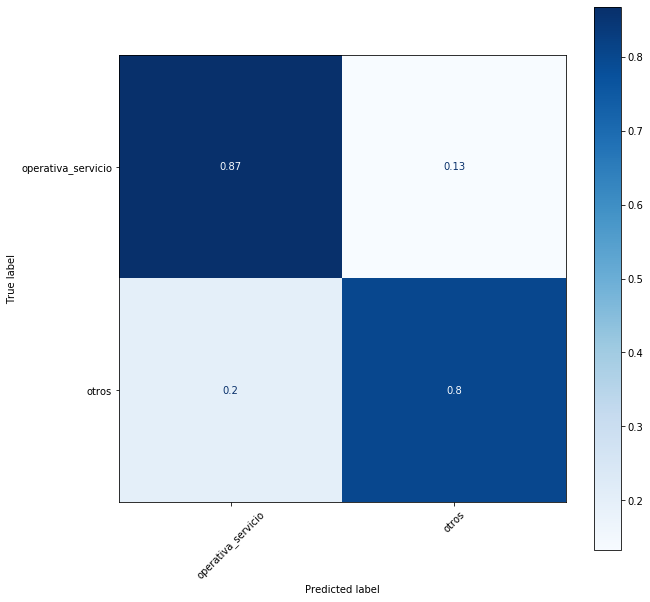

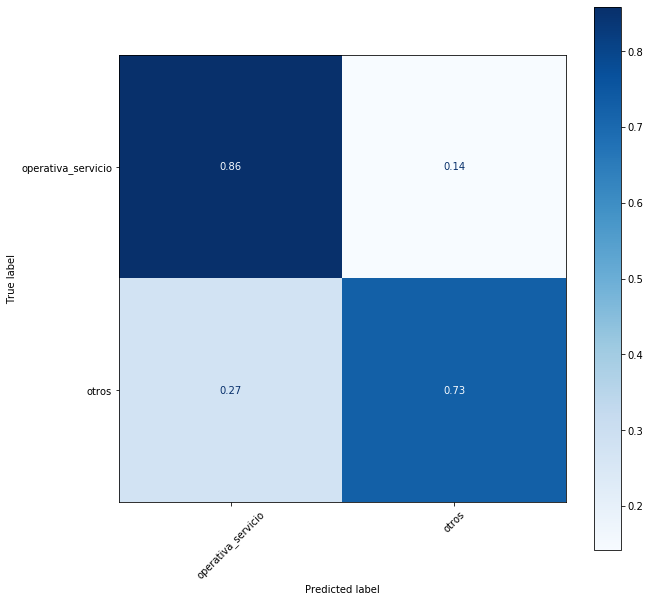

In [1122]:
sc.predictions_model_1()

In [1123]:
sc.preprocessing_model_2()

TRAIN:  80.0
TEST:  20.0


C:\Users\TGOBE1G\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\TGOBE1G\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\TGOBE1G\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://p

In [1124]:
sc.model_2()

C:\Users\TGOBE1G\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Accuracy Score: 0.8483412322274881
 
Confusion Matrix: 
[[638   9   9   3  42]
 [  9 209   3   2  42]
 [  4   2 194   6  19]
 [  5   4   4 408  41]
 [ 30  27   3  24 162]]
 
Area Under Curve: 0.9678184900542487
 
Micro F1 Score: 0.8483412322274881
 
Recall score: 0.8483412322274881
 
Precision score: 0.8483412322274881
 
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       701
           1       0.83      0.79      0.81       265
           2       0.91      0.86      0.89       225
           3       0.92      0.88      0.90       462
           4       0.53      0.66      0.59       246

    accuracy                           0.85      1899
   macro avg       0.82      0.82      0.82      1899
weighted avg       0.86      0.85      0.85      1899

 
Balanced Acuracy score: 0.8205366648010191
 
 
 
Accuracy Score: 0.8210526315789474
 
Confusion Matrix: 
[[137   3   2   2  18]
 [  1  57   0   0  12]
 [  0   1  63   1   4]
 [  1   1   

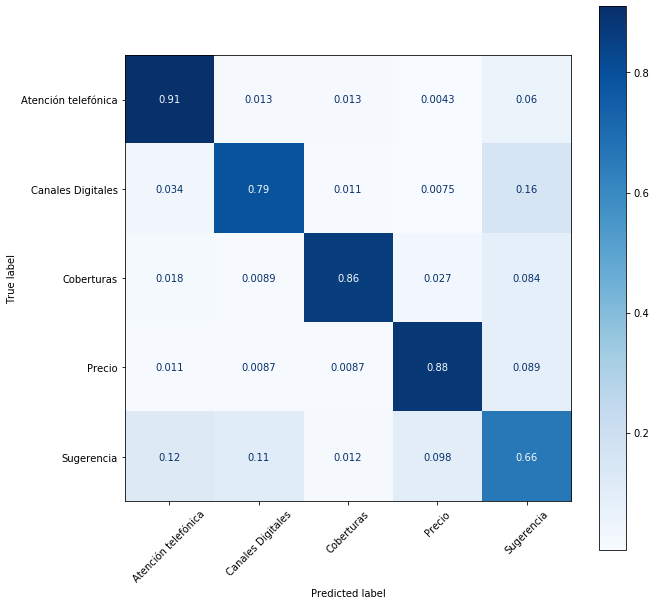

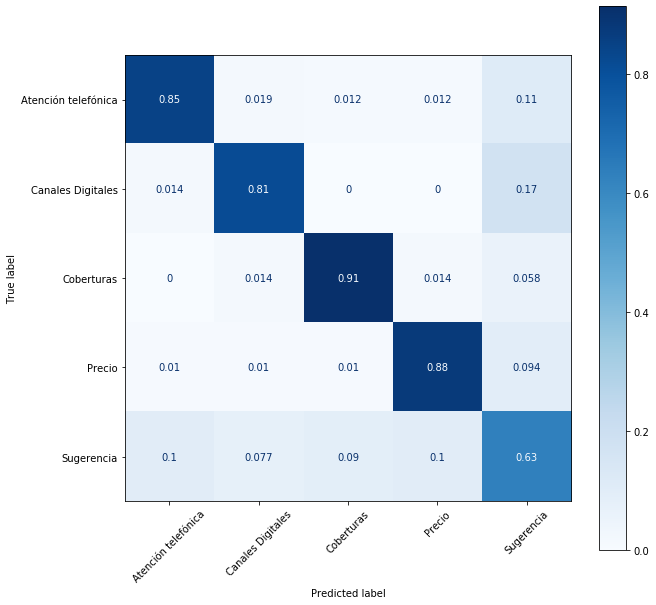

In [1125]:
sc.predictions_model_2()

In [1128]:
class semantic_classification_predictions:
    '''
    Clase que calcula las predicciones de categorías semánticas
    
    Los inputs que necesita la clase son:
    - path_variables_1: set de verbatims junto con las variables necesarias para predecir las categorías semánticas (modelo 1)
    - path_variables_2: set de verbatims junto con las variables necesarias para predecir las categorías semánticas (modelo 2)
    - path_df_utility_tagged: set de verbatims etiquetados como útiles/no útiles (solo utilizaremos los útiles)
    - mod_jerar1: modelo de clasificación semántica 1
    - mod_jerar2: modelo de clasificación semántica 2
    - to_drop_1: variables correlacionadas que deben eliminarse del dataset de verbatims (modelo 1)
    - to_drop_2: variables correlacionadas que deben eliminarse del dataset de verbatims (modelo 2)
    - le_1: clase que convierte las variables objetivo categóricas a numéricas (modelo 1) 
    - le_2: clase que convierte las variables objetivo categóricas a numéricas (modelo 2) 
    - te_1: clase que convierte las variables categóricas a numéricas (modelo 1) 
    - te_2: clase que convierte las variables categóricas a numéricas (modelo 2) 
    - df_labels: dataframe que contiene la converisón de variables categóricas a numéricas (modelo 2)
    '''
    def __init__(self, path_variables_1, path_variables_2, path_df_utility_tagged, mod_jerar1, mod_jerar2,\
                to_drop_1, to_drop_2, le_1, le_2, te_1, te_2, df_labels):

        # Leemos los ficheros de datos
        self.df_verb = pd.read_csv(path_variables_1, sep='#',index_col=0)
        self.df_verb_2 = pd.read_csv(path_variables_2, sep='#',index_col=0)
        self.df_utilidad=pd.read_csv(path_df_utility_tagged)
        
        # Seleccionamos únicamente los comentarios etiquetados como útiles para predecir las categorías a las que pertenecen
        self.idx_verbs_utiles = self.df_utilidad[self.df_utilidad['utilidad']=='util'].idcontacto.unique()
        self.df_verb = self.df_verb[self.df_verb.index.isin(self.idx_verbs_utiles)]
        # Verbatims que nuestro modelo de utilidad no ha categorizado como útiles pero que realmente lo son (son útiles
        # en el dataset etiquetado por negocio)
        self.idx_q_faltan = list(set(self.idx_verbs_utiles)-set(self.df_verb.index))
        self.df_verb_2 = self.df_verb_2[self.df_verb_2.index.isin(self.idx_verbs_utiles)]
        
        # Cargamos los modelos de predicción de categorías
        self.mod_class_1 = pickle.load(open(mod_jerar1, 'rb'))
        self.mod_class_2 = pickle.load(open(mod_jerar2, 'rb'))
        
        # Variables correlacionadas a eliminar
        self.to_drop_1 = to_drop_1
        self.to_drop_2 = to_drop_2
        
        # Label Encoder
        self.le_1 = le_1
        self.le_2 = le_2
        
        # Target Encoder
        self.te_1 = te_1
        self.te_2 = te_2        

        # df de conversión categoría-numérico
        self.df_labels = df_labels
        
    def model_1(self):
        '''
        Función que prepara el dataframe para las predicciones del modelo 1
        '''
        # Eliminamos columnas innecesarias para la predicción
        cols_avoided=['respuestaabierta', 'respuesta_corta', 'respuesta_corta_nodupl',
                     'operativa_servicio', 'otros', 'categoriai']
        self.df_test = self.df_verb.loc[:,~self.df_verb.columns.isin(cols_avoided)]
        # Transformamos la variables categóricas a numéricas
        self.df_test=self.te_1.transform(self.df_test)
        # Eliminamos las variables correlacionadas
        self.df_test.drop(columns=self.to_drop_1, inplace=True)
                
    def predictions_model_1(self):
        '''
        Función que calcula las predicciones junto con las correspondientes probabilidades con el modelo 1 
        '''
        # Calculamos las predicciones
        self.y_pred = self.mod_class_1.predict(self.df_test)
        # Convertimos los resultados a una variable categórica
        self.y_pred = self.le_1.inverse_transform(self.y_pred)
        # Calculamos las probabilidades
        self.y_pred_proba = self.mod_class_1.decision_function(self.df_test)
        probas_2d = np.c_[-self.y_pred_proba, self.y_pred_proba]
        self.final_t = softmax(probas_2d)[:,1]
        
        # Añadimos estos datos a un dataframe
        self.df_test['predictions_model_1'] = self.y_pred
        self.df_test['probabilities_model_1'] = self.final_t
        
        # Guardamos los índices de los comentarios categorizados como otros, ya que estos deberán pasar por el siguiente
        # modelo para ser clasificados en alguna de las variables minoritarias disponibles
        self.idx_mod_2 = self.df_test[self.df_test['predictions_model_1']=='otros'].index
        
        return(self.df_test[['predictions_model_1', 'probabilities_model_1']])

        
    def model_2(self):
        '''
        Función que prepara el dataframe para las predicciones del modelo 2
        '''
        # Eliminamos columnas innecesarias para la predicción
        cols_avoided=['respuestaabierta', 'respuesta_corta', 'respuesta_corta_nodupl',
                     'operativa_servicio', 'otros', 'categoriai']
        self.df_test_2 = self.df_verb_2.loc[:,~self.df_verb_2.columns.isin(cols_avoided)]
        self.df_test_2 = self.df_test_2[self.df_test_2.index.isin(self.idx_mod_2)]
        # Transformamos la variables categóricas a numéricas
        self.df_test_2= self.te_2.transform(self.df_test_2)
        # Eliminamos las variables correlacionadas
        self.df_test_2.drop(columns=self.to_drop_2, inplace=True)        
        
    def predictions_model_2(self):
        '''
        Función que calcula las predicciones junto con las correspondientes probabilidades con el modelo 2
        '''
        # Calculamos las predicciones
        self.y_pred_2 = self.mod_class_2.predict(self.df_test_2)
        # Convertimos los resultados a una variable categórica
        self.y_pred_2 = self.le_2.inverse_transform(self.y_pred_2)
        # Calculamos las probabilidades
        self.y_pred_proba_2 = self.mod_class_2.predict_proba(self.df_test_2)[:]
        
        
        # Añadimos estos datos a un dataframe

        # Guardamos las predicciones y las probabilidades en un dataframe
        self.df_test_2['predictions_model_2'] = self.y_pred_2
        list_names = ['Prob {}'.format(i).replace(' ','_') for i in self.df_labels.names.unique()]
        
        values = dict(zip(list_names, zip(*self.y_pred_proba_2)))
        values_df =pd.DataFrame(values)
        values_df.index = self.df_test_2.index
        self.df_test_2 = pd.concat([self.df_test_2, values_df], axis=1)

        list_names = ['predictions_model_2']+list_names
        return(self.df_test_2[list_names])

Ejecutamos la clase

In [1129]:
mod_jerar1= 'final_model_topic_class_jerar1_cat.sav'
mod_jerar2 ='final_model_topic_class_jerar2_cat.sav'
path_variables_1 = '2021-08-25_data_simulacion_categorias_jer1_martayana_v2.csv'
path_variables_2 = '2021-08-25_data_simulacion_categorias_jer2_martayana_v2.csv'
path_df_utility_tagged = 'predicciones_parte_utilidad_clases.csv'
to_drop_mod_1 = sc.to_drop
to_drop_mod_2 = sc.to_drop_2
target_encoder_1 = sc.te
target_encoder_2 = sc.te_2
label_encoder_1 = sc.le
label_encoder_2 = sc.le_2
df_labels_2 = sc.label_name_2

scp = semantic_classification_predictions(path_variables_1, path_variables_2, path_df_utility_tagged, mod_jerar1, mod_jerar2,\
                                         to_drop_mod_1, to_drop_mod_2, label_encoder_1, label_encoder_2,\
                                         target_encoder_1, target_encoder_2, df_labels_2)

In [1130]:
scp.model_1()

                      negocio perimetro     operativa                  etapa  \
idcontacto                                                                     
156864731   Auto Particulares  Autoclub     Servicios  4. Obtengo beneficios   
157695193   Auto Particulares  Autoclub     Servicios  4. Obtengo beneficios   
159259235   Auto Particulares  Autoclub     Servicios  4. Obtengo beneficios   
161677206   Auto Particulares  Autoclub     Servicios  4. Obtengo beneficios   
163939543   Auto Particulares  Autoclub     Servicios  4. Obtengo beneficios   
...                       ...       ...           ...                    ...   
219039274               Hogar     Hogar  Prestaciones     5. Uso mi producto   
217414219   Auto Particulares  Autoclub     Servicios  4. Obtengo beneficios   
217433444   Auto Particulares  Autoclub     Servicios  4. Obtengo beneficios   
217439213   Auto Particulares  Autoclub     Servicios  4. Obtengo beneficios   
217442686   Auto Particulares  Autoclub 

In [1131]:
df_class_1 = scp.predictions_model_1()

In [1132]:
scp.model_2()

In [1133]:
df_class_2 = scp.predictions_model_2()

Dataframe final que contiene las predicciones de categorías para cada verbatim

In [1175]:
df_piece_1 = df_class_1.join(df_class_2, how='left')

Las dos clases que se muestran a continuación son un pequeño "arreglo" para poder tener las predicciones de todos los verbatims. Con las clases anteriores obteníamos las predicciones para los verbatims cetagorizados como útiles. Sin embargo, en el dataframe utilizado para entrenar aparecen comentarios etiquetados como útiles que, por error de nuestro modelo de utilidad, nosotros hemos clasificado como "no útiles". Para repescar estos comentarios y asignarles una categoría se definen las siguientes dos clases:

In [1264]:
class classification_verbatims_left:
    def __init__(self, dataframe_ini, idx_q_faltan):
        self.df_ini = pd.read_excel(dataframe_ini)
        if idx_q_faltan =='all':
            self.df2 = self.df_ini[['IdContacto', 'Negocio', 'Perímetro', 'Operativa', 'Etapa',
       'Grupo Interacción', 'Contacto Pasillo', 'Respuesta Abierta']]
        else:
            self.df_ini = self.df_ini[self.df_ini.IdContacto.isin(idx_q_faltan)]
            self.df2 = self.df_ini[['IdContacto', 'Negocio', 'Perímetro', 'Operativa', 'Etapa',
           'Grupo Interacción', 'Contacto Pasillo', 'Respuesta Abierta']]

    # Eliminamos los acentos y convertimos y estandarizamos el texto a caracteres ASCII
    def remove_accented_chars(self, text):
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        return text
    
    # Eliminamos los caracteres especiales. Puesto que los números pueden ser de utilidad dependiendo de la finalidad del análisis, se deja como opcional su eliminación.
    def remove_special_characters(self, text, remove_digits=False, remove_dots=True, remove_accents=True):
        if not remove_dots and remove_accents==True:
            pattern = r'[^a-zA-z0-9.\s]' if not remove_digits else r'[^a-zA-z.\s]'
        if not remove_dots and remove_accents==False:
            pattern = r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ./]' if not remove_digits else r'[^ \nA-Za-z-À-ÖØ-öø-ÿ./]'
        if remove_dots==True and remove_accents==False:
            pattern = r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]' if not remove_digits else r'[^ \nA-Za-z-À-ÖØ-öø-ÿ/]'
        if remove_dots==True and remove_accents==True:
            pattern = r'[^ \nA-Za-z0-9/]' if not remove_digits else r'[^ \nA-Za-z/]'
        text = re.sub(pattern, '', text)
        return text
    
    # Eliminamos los caracteres especiales. Puesto que los números pueden ser de utilidad dependiendo de la finalidad del análisis, se deja como opcional su eliminación.
    def remove_special_characters_2(self, text):
        pattern = r'[^A-Za-z0-9 ]+'
        text = re.sub(pattern, '', text)
        return text

        # Eliminamos las stopwords
    def remove_stopwords(self, text, is_lower_case=False):
        tokens = tokenizer.tokenize(text)
        tokens = [token.strip() for token in tokens]
        if is_lower_case:
            filtered_tokens = [token for token in tokens if token not in stopword_list]
        else:
            filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
        filtered_text = ' '.join(filtered_tokens)    
        return filtered_text
    
    # Lematizamos el texto con la librería stanza
    def lemmatizer_stanza(self, text):
        doc = nlp_st(text)
        return ' '.join([word.lemma for sent in doc.sentences for word in sent.words])

    def lemmatizer_parallel(self, dataframe, numb):
        comment = self.lemmatizer_stanza(dataframe['respuesta_corta'].iloc[numb])
        return comment
        
    def preprocessing(self):
        variables = self.df2.columns
        newVariables = [x.replace(" ", "").lower() for x in variables]
        newVariables = [self.remove_accented_chars(x) for x in newVariables]
        self.df2.columns = newVariables
#         print(self.df2.head())
        
        self.df_duplis = self.df2[self.df2['respuestaabierta'].notna()].replace('\n','', regex=True)
        self.df_duplis['num_palabras'] = self.df_duplis.respuestaabierta.apply(lambda x: self.remove_special_characters(str(x))).str.split().str.len()
        self.df_duplis = self.df_duplis[self.df_duplis.num_palabras>3]
        idx = self.df_duplis.idcontacto.unique()
        del self.df_duplis
        
        self.df2 = self.df2[self.df2.idcontacto.isin(idx)]
        self.df2 = self.df2[self.df2['respuestaabierta'].notna()].replace('\n','', regex=True)
        self.df2['respuesta_corta'] = self.df2['respuestaabierta'].apply(lambda x: self.remove_special_characters(x, True, True, False))
        self.df2['respuesta_corta'] = self.df2['respuesta_corta'].apply(lambda x: x.lower())
        self.df2['respuesta_corta'] = self.df2['respuesta_corta'].apply(lambda x: self.remove_stopwords(x, False))
        self.df2['respuesta_corta'] = self.df2['respuesta_corta'].apply(lambda x: x.replace('  ', ' '))
        self.df2.replace(r'^\s*$', np.nan, regex=True, inplace=True)
        self.df2 = self.df2[self.df2['respuesta_corta'].notna()]

        results_2 = Parallel(n_jobs=-2, backend='threading', verbose=2)(delayed(self.lemmatizer_parallel)(self.df2, i) for i in range(len(self.df2.respuesta_corta)))
        self.df2['respuesta_corta'] = results_2
        
        self.df2['respuesta_corta'] = self.df2['respuesta_corta'].apply(lambda x: self.remove_stopwords(x, False))
        self.df2['respuesta_corta'] = self.df2['respuesta_corta'].apply(lambda x: self.remove_accented_chars(x))
        self.df2['respuesta_corta'] = self.df2['respuesta_corta'].apply(lambda x: self.remove_special_characters_2(x))
        
        self.df2.replace(r'^\s*$', np.nan, regex=True, inplace=True)
        self.df2 = self.df2[self.df2['respuesta_corta'].notna()]
        
        self.df2.respuesta_corta = self.df2.respuesta_corta.apply(lambda x: x.strip())
        self.df2['respuesta_corta_nodupl'] = self.df2['respuesta_corta'].apply(lambda x: " ".join((set(x.split()))))
        
        return(self.df2)

In [1136]:
cvl = classification_verbatims_left('verbatims_clasificados_marta_ana_v2.xlsx', scp.idx_q_faltan)

In [1137]:
df_q_falta = cvl.preprocessing()

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-2)]: Done 351 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-2)]: Done 634 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-2)]: Done 999 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-2)]: Done 1444 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-2)]: Done 1657 out of 1657 | elapsed:   50.7s finished


Verbatims útiles limpios y listos para crear el datset de variables en la plataforma

In [1065]:
df_q_falta.to_csv('prediccion_verbatim_categoria_v2_q_faltan.csv')

Ejecución de la clase "classification_verbatims_left" con todos los verbatims (no hay distinción entre útiles y no útiles)

In [1265]:
cvl_2 = classification_verbatims_left('verbatims_clasificados_marta_ana_v2.xlsx', 'all')

21885


In [1267]:
df_todos = cvl_2.preprocessing()

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-2)]: Done 351 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-2)]: Done 634 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-2)]: Done 999 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-2)]: Done 1444 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-2)]: Done 1971 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-2)]: Done 2578 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 3267 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done 4036 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done 4887 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-2)]: Done 5818 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-2)]: Done 6831 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-2)]: Done 7924 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-2)]: Done 9099 tasks    

In [1268]:
df_todos.to_csv('prediccion_verbatim_categoria_v2_todos_utilesynoutiles.csv')

In [1411]:
class semantic_classification_verbatims_left:
    
    def __init__(self, path_variables_1, path_variables_2, path_df_utility_tagged, mod_jerar1, mod_jerar2,\
                to_drop_1, to_drop_2, le_1, le_2, te_1, te_2, df_labels, jerar):

        self.df_verb = pd.read_csv(path_variables_1, sep='#',index_col=0)
        self.df_verb_2 = pd.read_csv(path_variables_2, sep='#',index_col=0)
        self.df_utilidad=pd.read_csv(path_df_utility_tagged)
        
        self.mod_class_1 = pickle.load(open(mod_jerar1, 'rb'))
        self.mod_class_2 = pickle.load(open(mod_jerar2, 'rb'))
        
        self.to_drop_1 = to_drop_1
        self.to_drop_2 = to_drop_2
        
        self.le_1 = le_1
        self.le_2 = le_2
        
        self.te_1 = te_1
        self.te_2 = te_2        

        self.df_labels = df_labels
        
        self.jerar_y_n = jerar
        
    def model_1(self):
        cols_avoided=['respuestaabierta', 'respuesta_corta', 'respuesta_corta_nodupl']
        self.df_test = self.df_verb.loc[:,~self.df_verb.columns.isin(cols_avoided)]
        self.df_test=self.te_1.transform(self.df_test)

        self.df_test.drop(columns=self.to_drop_1, inplace=True)
                
        
    def predictions_model_1(self):
        self.y_pred = self.mod_class_1.predict(self.df_test)
        self.y_pred = self.le_1.inverse_transform(self.y_pred)
        self.y_pred_proba = self.mod_class_1.decision_function(self.df_test)
        probas_2d = np.c_[-self.y_pred_proba, self.y_pred_proba]
        self.final_t = softmax(probas_2d)[:,1]
        
        self.df_test['predictions_model_1'] = self.y_pred
        self.df_test['probabilities_model_1'] = self.final_t

        self.idx_mod_2 = self.df_test[self.df_test['predictions_model_1']=='otros'].index
        
        return(self.df_test[['predictions_model_1', 'probabilities_model_1']])

        
    def model_2(self):
        cols_avoided=['respuestaabierta', 'respuesta_corta', 'respuesta_corta_nodupl',
                     'operativa_servicio', 'otros', 'categoriai']
        self.df_test_2 = self.df_verb_2.loc[:,~self.df_verb_2.columns.isin(cols_avoided)]
        if self.jerar_y_n==True:
            self.df_test_2 = self.df_test_2[self.df_test_2.index.isin(self.idx_mod_2)]
            self.df_test_2= self.te_2.transform(self.df_test_2)
        else:
            self.df_test_2= self.te_2.transform(self.df_test_2)

        self.df_test_2.drop(columns=self.to_drop_2, inplace=True)        
        
    def predictions_model_2(self):

        self.y_pred_2 = self.mod_class_2.predict(self.df_test_2)
        self.y_pred_2 = self.le_2.inverse_transform(self.y_pred_2)
        self.y_pred_proba_2 = self.mod_class_2.predict_proba(self.df_test_2)[:]
        
        self.df_test_2['predictions_model_2'] = self.y_pred_2
        list_names = ['Prob {}'.format(i).replace(' ','_') for i in self.df_labels.names.unique()]
        
        values = dict(zip(list_names, zip(*self.y_pred_proba_2)))
        values_df =pd.DataFrame(values)
        values_df.index = self.df_test_2.index
        self.df_test_2 = pd.concat([self.df_test_2, values_df], axis=1)

        list_names = ['predictions_model_2']+list_names
        return(self.df_test_2[list_names])

Ejecución de la clase para los verbatims útiles que faltan

In [1269]:
mod_jerar1= 'final_model_topic_class_jerar1_cat.sav'
mod_jerar2 ='final_model_topic_class_jerar2_cat.sav'
path_variables_1_q_faltan = '2021-08-25_data_simulacion_categorias_jer1_martayana_v2_q_faltan.csv'
path_variables_2_q_faltan = '2021-08-25_data_simulacion_categorias_jer2_martayana_v2_q_faltan.csv'
path_variables_1_todos = '2021-08-26_data_simulacion_categorias_jer1_martayana_v2_todos_utilesynoutiles.csv'
path_variables_2_todos = '2021-08-26_data_simulacion_categorias_jer2_martayana_v2_todos_utilesynoutiles.csv'
path_df_utility_tagged = 'predicciones_parte_utilidad_clases.csv'
to_drop_mod_1 = sc.to_drop
to_drop_mod_2 = sc.to_drop_2
target_encoder_1 = sc.te
target_encoder_2 = sc.te_2
label_encoder_1 = sc.le
label_encoder_2 = sc.le_2
df_labels_2 = sc.label_name_2

In [1162]:
scvl = semantic_classification_verbatims_left(path_variables_1_q_faltan, path_variables_2_q_faltan, path_df_utility_tagged,mod_jerar1, mod_jerar2,\
                                             to_drop_mod_1, to_drop_mod_2, label_encoder_1,label_encoder_2, target_encoder_1, target_encoder_2,
                                              df_labels_2, True)

In [1168]:
scvl.model_1()

In [1169]:
df_class_1_1 = scvl.predictions_model_1()

In [1171]:
scvl.model_2()

In [1172]:
df_class_2_2=scvl.predictions_model_2()

In [1174]:
df_piece_2 = df_class_1_1.join(df_class_2_2, how='left')

Ejecución de la clase para todos los verbatims

In [1270]:
scvl_t = semantic_classification_verbatims_left(path_variables_1_todos, path_variables_2_todos, path_df_utility_tagged,mod_jerar1, mod_jerar2,\
                                             to_drop_mod_1, to_drop_mod_2, label_encoder_1,label_encoder_2, target_encoder_1, target_encoder_2,
                                              df_labels_2, True)

In [1271]:
scvl_t.model_1()

In [1272]:
df_class_1_1_t = scvl_t.predictions_model_1()

In [1274]:
scvl_t.model_2()

In [1276]:
df_class_2_2_t=scvl_t.predictions_model_2()

In [1277]:
df_piece_2_t = df_class_1_1_t.join(df_class_2_2_t, how='left')

Ejecución de la clase para todos los verbatims sin jerarquizar modelos, es decir, todos los verbatims pasan por el modelo 1 y por el 2

In [1412]:
scvl_t_nojerar = semantic_classification_verbatims_left(path_variables_1_todos, path_variables_2_todos, path_df_utility_tagged,mod_jerar1, mod_jerar2,\
                                             to_drop_mod_1, to_drop_mod_2, label_encoder_1,label_encoder_2, target_encoder_1, target_encoder_2,
                                              df_labels_2, False)

In [1413]:
scvl_t_nojerar.model_1()

In [1414]:
df_class_1_1_t_nojerar = scvl_t_nojerar.predictions_model_1()

In [1415]:
scvl_t_nojerar.model_2()

In [1416]:
df_class_2_2_t_nojerar=scvl_t_nojerar.predictions_model_2()

In [1417]:
df_piece_2_t_nojerar = df_class_1_1_t_nojerar.join(df_class_2_2_t_nojerar, how='left')

### Creación del DataFrame con las predicciones de utilidad y categorías

Sin distinción entre útil/no útil, es decir, todos los verbatims

In [1558]:
df_piece_final_t_nojerar = df_final_1.join(df_piece_2_t_nojerar, how='left', on='idcontacto', lsuffix='_')

In [1559]:
df_martana = u.df[['idcontacto','canal','negocio','perimetro','operativa','etapa','grupointeraccion','contactopasillo',
 'indicadorsatisfaccionservicio','indicadorsatisfaccionagente',
 'respuestaabierta','utilidadverbatim', 'sentimenti', 'categoriai']].set_index('idcontacto')

In [1560]:
cols_merge=['idcontacto','canal','negocio','perimetro','operativa','etapa','grupointeraccion','contactopasillo',
 'indicadorsatisfaccionservicio','indicadorsatisfaccionagente',
 'respuestaabierta']

In [1561]:
len(df_piece_final_t_nojerar)

40657

In [1562]:
idx_tr_1 = [int(i) for i in sc.idx_train_1]
idx_t_1 = [int(i) for i in sc.idx_test_1]

idx_tr_2 = [int(i) for i in sc.idx_train_2]
idx_t_2 = [int(i) for i in sc.idx_test_2]

In [1563]:
df_piece_final_t_nojerar['model_1']=np.nan
df_piece_final_t_nojerar.loc[df_piece_final_t_nojerar.index.isin(idx_tr_1),'model_1']='train_model_1'
df_piece_final_t_nojerar.loc[df_piece_final_t_nojerar.index.isin(idx_t_1),'model_1']='test_model_1'

df_piece_final_t_nojerar['model_2']=np.nan
df_piece_final_t_nojerar.loc[df_piece_final_t_nojerar.index.isin(idx_tr_2),'model_2']='train_model_2'
df_piece_final_t_nojerar.loc[df_piece_final_t_nojerar.index.isin(idx_t_2),'model_2']='test_model_2'

In [1564]:
grpb_nojerar=df_piece_final_t_nojerar.groupby('idcontacto')

In [1565]:
df_res = grpb_nojerar['utilidad_frases'].apply(lambda x: pd.Series(x.values)).unstack()
df_res = df_res.rename(columns={i: 'utilidad_frase_{}'.format(i + 1) for i in range(len(df_res))})

df_res_1 = grpb_nojerar['prob_pos'].apply(lambda x: pd.Series(x.values)).unstack()
df_res_1 = df_res_1.rename(columns={i: 'prob_pos_{}'.format(i + 1) for i in range(len(df_res))})

df_res_2 = grpb_nojerar['prob_neg'].apply(lambda x: pd.Series(x.values)).unstack()
df_res_2 = df_res_2.rename(columns={i: 'prob_neg_{}'.format(i + 1) for i in range(len(df_res))})

df_res_3 = grpb_nojerar['prob_neu'].apply(lambda x: pd.Series(x.values)).unstack()
df_res_3 = df_res_3.rename(columns={i: 'prob_neu_{}'.format(i + 1) for i in range(len(df_res))})

In [1566]:
df_grpb_nojerar = df_res.join(df_res_1, how='left', on ='idcontacto').join(df_res_2, how='left', on ='idcontacto').join(df_res_3, how='left', on ='idcontacto')

In [1567]:
df_piece_final_t_dupl_nojerar =df_piece_final_t_nojerar.join(df_grpb_nojerar, how='left', on='idcontacto')

In [1569]:
df_piece_final_t_dupl_nojerar.reset_index(inplace=True)

In [1570]:
df_piece_final_t_dupl_nojerar =df_piece_final_t_dupl_nojerar.drop_duplicates(subset='idcontacto', keep='first').set_index('idcontacto')

In [1572]:
ut =['utilidad_frase_{}'.format(i) for i in range(1,len(df_res.columns)+1)]
pos =['prob_pos_{}'.format(i) for i in range(1,len(df_res.columns)+1)]
neg =['prob_neg_{}'.format(i) for i in range(1,len(df_res.columns)+1)]
neu =['prob_neu_{}'.format(i) for i in range(1,len(df_res.columns)+1)]

In [1573]:
cols=[]
for i,j,l,k in zip(ut, pos, neg, neu):
    cols.append(i)
    cols.append(j)
    cols.append(l)
    cols.append(k)

In [1574]:
cols=["canal", "negocio", "perimetro", "operativa", "etapa", "grupointeraccion",\
 "contactopasillo", "indicadorsatisfaccionservicio", "indicadorsatisfaccionagente", "satis_cat", "respuestaabierta"]+cols+\
["utilidad", "alta_satis", "baja_satis", "media_satis", "predictions_model_1", "probabilities_model_1", "predictions_model_2",\
 "Prob_Atención_telefónica", "Prob_Canales_Digitales", "Prob_Coberturas", "Prob_Precio", "Prob_Sugerencia", "utilidadverbatim",\
 "sentimenti", "categoriai", "model_1", "model_2"]

In [1597]:
df_piece_final_t_dupl_nojerar_2=pd.concat([df_piece_final_t_dupl_nojerar.reindex(df_martana.index), df_martana], axis=1)

In [1604]:
df_piece_final_t_dupl_nojerar_2[cols].to_excel('predicciones_ciclo_completo_vozcliente_unstack_nojerar.xlsx')

In [1186]:
df_piece_1_1 = pd.concat([df_piece_1, df_piece_2])

In [1312]:
# df_piece_1_1_t = pd.concat([df_piece_1, df_piece_2_t])

In [1283]:
len(df_piece_1_1_t)

23104

In [1285]:
df_piece_1_1.head(2)

,predictions_model_1,probabilities_model_1,predictions_model_2,Prob_Atención_telefónica,Prob_Canales_Digitales,Prob_Coberturas,Prob_Precio,Prob_Sugerencia
idcontacto,,,,,,,,
156864731,operativa_servicio,0.368957,NaN,NaN,NaN,NaN,NaN,NaN
157695193,operativa_servicio,0.267501,NaN,NaN,NaN,NaN,NaN,NaN


In [1190]:
df_final_1 = df_final.set_index('idcontacto')

In [1317]:
df_piece_final_t = df_final_1.join(df_piece_2_t, how='left', on='idcontacto', lsuffix='_')

In [1390]:
len(df_final_1[['respuestaabierta', 'utilidad']].index.unique().values)

14058

In [1278]:
df_piece_final = df_final_1.join(df_piece_1_1, how='left', on='idcontacto', lsuffix='_')

NameError: name 'df_piece_1_1_t' is not defined

In [1195]:
len(df_final_1)

40657

In [1201]:
df_martana = u.df[['idcontacto', 'utilidadverbatim', 'sentimenti', 'categoriai']].set_index('idcontacto')

In [1208]:
len(df_piece_final)

40657

In [1318]:
df_piece_final_t = df_piece_final_t.join(df_martana, how='left', on='idcontacto', lsuffix='_')

In [1202]:
df_piece_final = df_piece_final.join(df_martana, how='left', on='idcontacto', lsuffix='_')

In [1252]:
idx_tr_1 = [int(i) for i in sc.idx_train_1]
idx_t_1 = [int(i) for i in sc.idx_test_1]

idx_tr_2 = [int(i) for i in sc.idx_train_2]
idx_t_2 = [int(i) for i in sc.idx_test_2]

In [1253]:
df_piece_final['model_1']=np.nan
df_piece_final.loc[df_piece_final.index.isin(idx_tr_1),'model_1']='train_model_1'
df_piece_final.loc[df_piece_final.index.isin(idx_t_1),'model_1']='test_model_1'

df_piece_final['model_2']=np.nan
df_piece_final.loc[df_piece_final.index.isin(idx_tr_2),'model_2']='train_model_2'
df_piece_final.loc[df_piece_final.index.isin(idx_t_2),'model_2']='test_model_2'

In [1319]:
df_piece_final_t['model_1']=np.nan
df_piece_final_t.loc[df_piece_final_t.index.isin(idx_tr_1),'model_1']='train_model_1'
df_piece_final_t.loc[df_piece_final_t.index.isin(idx_t_1),'model_1']='test_model_1'

df_piece_final_t['model_2']=np.nan
df_piece_final_t.loc[df_piece_final_t.index.isin(idx_tr_2),'model_2']='train_model_2'
df_piece_final_t.loc[df_piece_final_t.index.isin(idx_t_2),'model_2']='test_model_2'

In [1321]:
grpb=df_piece_final_t.groupby('idcontacto')

In [1333]:
df_res = grpb['utilidad_frases'].apply(lambda x: pd.Series(x.values)).unstack()
df_res = df_res.rename(columns={i: 'utilidad_frase_{}'.format(i + 1) for i in range(len(df_res))})

df_res_1 = grpb['prob_pos'].apply(lambda x: pd.Series(x.values)).unstack()
df_res_1 = df_res_1.rename(columns={i: 'prob_pos_{}'.format(i + 1) for i in range(len(df_res))})

df_res_2 = grpb['prob_neg'].apply(lambda x: pd.Series(x.values)).unstack()
df_res_2 = df_res_2.rename(columns={i: 'prob_neg_{}'.format(i + 1) for i in range(len(df_res))})

df_res_3 = grpb['prob_neu'].apply(lambda x: pd.Series(x.values)).unstack()
df_res_3 = df_res_3.rename(columns={i: 'prob_neu_{}'.format(i + 1) for i in range(len(df_res))})


In [1363]:
df_grpb = df_res.join(df_res_1, how='left', on ='idcontacto').join(df_res_2, how='left', on ='idcontacto').join(df_res_3, how='left', on ='idcontacto')

In [1365]:
df_piece_final_t_dupl=df_piece_final_t.join(df_grpb, how='left', on='idcontacto')

In [1366]:
df_piece_final_t_dupl.reset_index(inplace=True)

In [1367]:
df_piece_final_t_dupl =df_piece_final_t_dupl.drop_duplicates(subset='idcontacto', keep='first').set_index('idcontacto')

In [1372]:
ut =['utilidad_frase_{}'.format(i) for i in range(1,25)]
pos =['prob_pos_{}'.format(i) for i in range(1,25)]
neg =['prob_neg_{}'.format(i) for i in range(1,25)]
neu =['prob_neu_{}'.format(i) for i in range(1,25)]

In [1374]:
cols=[]
for i,j,l,k in zip(ut, pos, neg, neu):
    cols.append(i)
    cols.append(j)
    cols.append(l)
    cols.append(k)

In [1379]:
cols=["id_unico", "canal", "negocio", "perimetro", "operativa", "etapa", "grupointeraccion",\
 "contactopasillo", "indicadorsatisfaccionservicio", "indicadorsatisfaccionagente", "satis_cat", "respuestaabierta"]+cols+\
["utilidad", "alta_satis", "baja_satis", "media_satis", "predictions_model_1", "probabilities_model_1", "predictions_model_2",\
 "Prob_Atención_telefónica", "Prob_Canales_Digitales", "Prob_Coberturas", "Prob_Precio", "Prob_Sugerencia", "utilidadverbatim",\
 "sentimenti", "categoriai", "model_1", "model_2"]

In [1383]:
len(u.df)

21885

In [1380]:
df_piece_final_t_dupl[cols]

,id_unico,canal,negocio,perimetro,operativa,etapa,grupointeraccion,contactopasillo,indicadorsatisfaccionservicio,indicadorsatisfaccionagente,...,Prob_Atención_telefónica,Prob_Canales_Digitales,Prob_Coberturas,Prob_Precio,Prob_Sugerencia,utilidadverbatim,sentimenti,categoriai,model_1,model_2
idcontacto,,,,,,,,,,,,,,,,,,,,,
155330379,155330379_0,IVR,Auto Particulares,Autoclub,Servicios,4. Obtengo beneficios,A.4.6 Alquilo un coche,Contrato y uso coche de alquiler a través de M...,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,Útil,Neutro,Sugerencia,test_model_1,test_model_2
156864731,156864731_4,IVR,Auto Particulares,Autoclub,Servicios,4. Obtengo beneficios,A.4.6 Alquilo un coche,Contrato y uso coche de alquiler a través de M...,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,Útil,Positivo,Operativa / servicio,train_model_1,NaN
157695193,157695193_8,IVR,Auto Particulares,Autoclub,Servicios,4. Obtengo beneficios,A.4.6 Alquilo un coche,Contrato y uso coche de alquiler a través de M...,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,Útil,Positivo,Operativa / servicio,test_model_1,NaN
158254041,158254041_13,IVR,Auto Particulares,Autoclub,Servicios,4. Obtengo beneficios,A.4.6 Alquilo un coche,Contrato y uso coche de alquiler a través de M...,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,No Útil,NaN,NaN,NaN,NaN
159259235,159259235_15,Email,Auto Particulares,Autoclub,Servicios,4. Obtengo beneficios,A.4.6 Alquilo un coche,Contrato y uso coche de alquiler a través de M...,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,Útil,Positivo,Satisfacción General,NaN,NaN
159565531,159565531_17,IVR,Auto Particulares,Autoclub,Servicios,4. Obtengo beneficios,A.4.6 Alquilo un coche,Contrato y uso coche de alquiler a través de M...,5.0,5.0,...,0.002619,0.003206,0.003314,0.748170,0.242691,Útil,Neutro,Sugerencia,train_model_1,train_model_2
159848732,159848732_27,IVR,Auto Particulares,Autoclub,Servicios,4. Obtengo beneficios,A.4.6 Alquilo un coche,Contrato y uso coche de alquiler a través de M...,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,No Útil,NaN,NaN,NaN,NaN
159870023,159870023_29,Email,Auto Particulares,Autoclub,Servicios,4. Obtengo beneficios,A.4.6 Alquilo un coche,Contrato y uso coche de alquiler a través de M...,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,Útil,Negativo,Operativa / servicio,test_model_1,NaN
161234408,161234408_30,IVR,Auto Particulares,Autoclub,Servicios,4. Obtengo beneficios,A.4.6 Alquilo un coche,Contrato y uso coche de alquiler a través de M...,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,No Útil,NaN,NaN,NaN,NaN


In [1381]:
df_piece_final_t_dupl[cols].to_excel('predicciones_ciclo_completo_vozcliente_unstack.xlsx')

In [1394]:
idx_mas4 = df_piece_final_t_dupl.index.unique()

In [1401]:
idx_mas4 = df_piece_final_t_dupl.index.unique()
df_add = u.df[~u.df.idcontacto.isin(idx_mas4)][['idcontacto',
 'canal',
 'negocio',
 'perimetro',
 'operativa',
 'etapa',
 'grupointeraccion',
 'contactopasillo',
 'indicadorsatisfaccionservicio',
 'indicadorsatisfaccionagente',
 'respuestaabierta',
 'utilidadverbatim',
 'sentimenti',
 'categoriai']]

In [1402]:
df_add=df_add.set_index('idcontacto')

In [1404]:
df_piece_final_t_dupl.loc[155330379]

id_unico                                                               155330379_0
canal                                                                          IVR
negocio                                                          Auto Particulares
perimetro                                                                 Autoclub
operativa                                                                Servicios
etapa                                                        4. Obtengo beneficios
grupointeraccion                                            A.4.6 Alquilo un coche
contactopasillo                  Contrato y uso coche de alquiler a través de M...
indicadorsatisfaccionservicio                                                    5
indicadorsatisfaccionagente                                                      3
satis_cat                                                                        1
respuestaabierta                 Quería bueno que hubiese alquiler de mediodía....
resp

In [1409]:
pd.concat([df_piece_final_t_dupl[cols],df_add], sort='False')[cols].to_excel('predicciones_completas_final.xlsx')